In [1]:
"""
copperheadV1 test
"""
import glob
import dask_awkward as dak
import awkward as ak
import pandas as pd
from distributed import Client
 

def applyVBF_cutV1(events, variation="nominal"):
    btag_cut =ak.fill_none((events[f"nBtagLoose_{variation}"] >= 2), value=False) | ak.fill_none((events[f"nBtagMedium_{variation}"] >= 1), value=False)
    # vbf_cut = ak.fill_none(events.vbf_cut, value=False
    vbf_cut = (events[f"jj_mass_{variation}"] > 400) & (events[f"jj_dEta_{variation}"] > 2.5) & (events[f"jet1_pt_{variation}"] > 35) 
    vbf_cut = ak.fill_none(vbf_cut, value=False)
    # region = events.h_peak 
    # region = events.h_sidebands | events.h_peak
    # region = events.h_sidebands 
    dimuon_mass = events.dimuon_mass
    # region = (dimuon_mass >= 110) & (dimuon_mass <= 150.0)
    region = (dimuon_mass > 115.03) & (dimuon_mass < 135.03)
    # region = (dimuon_mass > 115.0) & (dimuon_mass < 135.0)
    # region = ((dimuon_mass > 110) & (dimuon_mass < 115.03)) | ((dimuon_mass > 135.03) & (dimuon_mass < 150))

    # region = (events.region == "h-peak") | (events.region == "h-sidebands")
    # region = events.region == "h-sidebands""""
    VBF_filter = (
        vbf_cut & 
        region &
        ~btag_cut # btag cut is for VH and ttH categories
    )
    trues = ak.ones_like(dimuon_mass, dtype="bool")
    falses = ak.zeros_like(dimuon_mass, dtype="bool")
    events["vbf_filter"] = ak.where(VBF_filter, trues,falses)
    return events[VBF_filter]
    # return events

def applyGGH_cutV1(events):
    btag_cut =ak.fill_none((events.nBtagLoose_nominal >= 2), value=False) | ak.fill_none((events.nBtagMedium_nominal >= 1), value=False)
    vbf_cut = (events.jj_mass_nominal > 400) & (events.jj_dEta_nominal > 2.5)
    # vbf_cut = (events.jj_mass_nominal > 400) & (events.jj_dEta_nominal > 2.5) & (events.jet1_pt_nominal > 35) 
    vbf_cut = ak.fill_none(vbf_cut, value=False)
    dimuon_mass = events.dimuon_mass
    region = (dimuon_mass >= 110) & (dimuon_mass <= 150.0)
    # region = ((dimuon_mass > 110) & (dimuon_mass < 115.03)) | ((dimuon_mass > 135.03) & (dimuon_mass < 150))
    # region = events.region == "h-peak"
    # region = events.region == "h-sidebands"
    ggH_filter = (
        ~vbf_cut & 
        region &
        ~btag_cut # btag cut is for VH and ttH categories
    )
    return events[ggH_filter]



In [2]:
client =  Client(n_workers=61,  threads_per_worker=1, processes=True, memory_limit='4 GiB') 
V1_fields_2compute = [
    "wgt_nominal",
    "nBtagLoose_nominal",
    "nBtagMedium_nominal",
    "nBtagLoose_Absolute_down",
    "nBtagMedium_Absolute_down",
    "nBtagLoose_Absolute_up",
    "nBtagMedium_Absolute_up",
    # "mu1_pt",
    # "mu2_pt",
    # "mu1_eta",
    # "mu2_eta",
    # "mu1_phi",
    # "mu2_phi",
    # "dimuon_pt",
    # "dimuon_eta",
    # "dimuon_phi",
    "dimuon_mass",
    "jet1_phi_nominal",
    "jet1_pt_nominal",
    "jet2_pt_nominal",
    "jet2_phi_nominal",
    "jet1_eta_nominal",
    "jet2_eta_nominal",
    "jj_mass_nominal",
    "jj_dEta_nominal",
    "jet1_phi_Absolute_up",
    "jet1_pt_Absolute_up",
    "jet2_pt_Absolute_up",
    "jet2_phi_Absolute_up",
    "jet1_eta_Absolute_up",
    "jet2_eta_Absolute_up",
    "jj_mass_Absolute_up",
    "jj_dEta_Absolute_up",
    "jet1_phi_Absolute_down",
    "jet1_pt_Absolute_down",
    "jet2_pt_Absolute_down",
    "jet2_phi_Absolute_down",
    "jet1_eta_Absolute_down",
    "jet2_eta_Absolute_down",
    "jj_mass_Absolute_down",
    "jj_dEta_Absolute_down",
    # "region",
    "event",
    'jet1_pt_Absolute_down', 'jet1_eta_Absolute_down', 'jet1_phi_Absolute_down', 
    'jet1_qgl_Absolute_down', 'jet2_pt_Absolute_down', 'jet2_eta_Absolute_down', 'jet2_phi_Absolute_down', 'jet2_qgl_Absolute_down', 
    'jj_mass_Absolute_down', 'jj_mass_log_Absolute_down', 'jj_dEta_Absolute_down', 'rpt_Absolute_down', 'll_zstar_log_Absolute_down', 
    'mmj_min_dEta_Absolute_down', 'nsoftjets5_Absolute_down', 'htsoft2_Absolute_down',
    'jet1_pt_Absolute_up', 'jet1_eta_Absolute_up', 'jet1_phi_Absolute_up', 
    'jet1_qgl_Absolute_up', 'jet2_pt_Absolute_up', 'jet2_eta_Absolute_up', 'jet2_phi_Absolute_up', 'jet2_qgl_Absolute_up', 
    'jj_mass_Absolute_up', 'jj_mass_log_Absolute_up', 'jj_dEta_Absolute_up', 'rpt_Absolute_up', 'll_zstar_log_Absolute_up', 
    'mmj_min_dEta_Absolute_up', 'nsoftjets5_Absolute_up', 'htsoft2_Absolute_up',
    'dimuon_pt', 'dimuon_pt_log', 'dimuon_eta', 'dimuon_pisa_mass_res', 'dimuon_pisa_mass_res_rel', 
    'dimuon_cos_theta_cs_pisa', 'dimuon_phi_cs_pisa',
    'jet1_qgl_nominal', 'jet2_pt_nominal', 'jet2_eta_nominal', 'jet2_phi_nominal', 'jet2_qgl_nominal', 
    'jj_mass_nominal', 'jj_mass_log_nominal', 'jj_dEta_nominal', 'rpt_nominal', 'll_zstar_log_nominal', 
    'mmj_min_dEta_nominal', 'nsoftjets5_nominal', 'htsoft2_nominal',
    'dimuon_pt', 'dimuon_pt_log', 'dimuon_eta', 'dimuon_pisa_mass_res', 'dimuon_pisa_mass_res_rel', 
    'dimuon_cos_theta_cs_pisa', 'dimuon_phi_cs_pisa',
]
V1_fields_2compute = list(set(V1_fields_2compute))

year = "2018"

# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/rereco_yun_JecDefaultZptOnJecUncOn_Nov20/stage1_output/{year}/"

# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/JecOffGfOnZptOn_Nov21/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/RERECO_official_Nov22/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/RERECO_official_JECoff_Nov22/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/RERECO_private_JecOn_Nov22/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/pisaData_Nov23/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/pisaDataJecOff_Nov23/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/pisaData_May2020Ver_Nov23/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/pisaData_May2020VerGfOff_Nov23/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/test_Nov24/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/rereco_yun_Nov25/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/rereco_yun_Nov25_puidWgtOff/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/rereco_yun_Nov27_puidWgtOn/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/rereco_yun_Dec04_trigmatchOn/stage1_output/{year}/"
load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/rereco_yun_Nov26_puidWgtOnJerUncOn/stage1_output/{year}/"
# load_path =f"/depot/cms/users/yun79/hmm/copperheadV1clean/rereco_yun_Dec04NewBtag/stage1_output/{year}/"


total_integral = 0

# events = dak.from_parquet(f"{load_path}/data_*/*.parquet")

# filelist = glob.glob(f"{load_path}/data_*/*.parquet")
# filelist = glob.glob(f"{load_path}/ggh_amcPS/*.parquet")
filelist = glob.glob(f"{load_path}/vbf_powheg_dipole/*.parquet")
# print(events_data.fields)
# events_data.fields

In [3]:
events = dak.from_parquet(filelist)

In [4]:
njet_fields =[]
for field in events.fields:
    if "njet" in field:
        njet_fields.append(field)

njet_fields

['njets_Absolute2018_down',
 'njets_Absolute2018_up',
 'njets_Absolute_down',
 'njets_Absolute_up',
 'njets_BBEC12018_down',
 'njets_BBEC12018_up',
 'njets_BBEC1_down',
 'njets_BBEC1_up',
 'njets_EC22018_down',
 'njets_EC22018_up',
 'njets_EC2_down',
 'njets_EC2_up',
 'njets_FlavorQCD_down',
 'njets_FlavorQCD_up',
 'njets_HF2018_down',
 'njets_HF2018_up',
 'njets_HF_down',
 'njets_HF_up',
 'njets_RelativeBal_down',
 'njets_RelativeBal_up',
 'njets_RelativeSample2018_down',
 'njets_RelativeSample2018_up',
 'njets_jer1_down',
 'njets_jer1_up',
 'njets_jer2_down',
 'njets_jer2_up',
 'njets_jer3_down',
 'njets_jer3_up',
 'njets_jer4_down',
 'njets_jer4_up',
 'njets_jer5_down',
 'njets_jer5_up',
 'njets_jer6_down',
 'njets_jer6_up',
 'njets_nominal']

In [17]:
# ! ls /depot/cms/users/yun79/hmm/copperheadV1clean/RERECO_official_Nov22/stage1_output/2018/data_D

In [18]:
events.fields

['dataset',
 'dimuon_cos_theta_cs',
 'dimuon_cos_theta_cs_pisa',
 'dimuon_dEta',
 'dimuon_dPhi',
 'dimuon_dR',
 'dimuon_ebe_mass_res',
 'dimuon_ebe_mass_res_rel',
 'dimuon_eta',
 'dimuon_mass',
 'dimuon_phi',
 'dimuon_phi_cs',
 'dimuon_phi_cs_pisa',
 'dimuon_pisa_mass_res',
 'dimuon_pisa_mass_res_rel',
 'dimuon_pt',
 'dimuon_pt_log',
 'event',
 'gjet1_eta',
 'gjet1_mass',
 'gjet1_phi',
 'gjet1_pt',
 'gjet2_eta',
 'gjet2_mass',
 'gjet2_phi',
 'gjet2_pt',
 'gjj_dEta',
 'gjj_dPhi',
 'gjj_dR',
 'gjj_eta',
 'gjj_mass',
 'gjj_phi',
 'gjj_pt',
 'htsoft2_Absolute2018_down',
 'htsoft2_Absolute2018_up',
 'htsoft2_Absolute_down',
 'htsoft2_Absolute_up',
 'htsoft2_BBEC12018_down',
 'htsoft2_BBEC12018_up',
 'htsoft2_BBEC1_down',
 'htsoft2_BBEC1_up',
 'htsoft2_EC22018_down',
 'htsoft2_EC22018_up',
 'htsoft2_EC2_down',
 'htsoft2_EC2_up',
 'htsoft2_FlavorQCD_down',
 'htsoft2_FlavorQCD_up',
 'htsoft2_HF2018_down',
 'htsoft2_HF2018_up',
 'htsoft2_HF_down',
 'htsoft2_HF_up',
 'htsoft2_RelativeBal_down',


In [6]:
fields2exclude = ['separate_wgt_genwgt', 'separate_wgt_lumi',]

fields2deactivate = []
for field in events.fields:
    if "separate" in field:
        if field not in fields2exclude:
            fields2deactivate.append(field)
V1_fields_2compute += fields2deactivate

In [7]:
# fields2play = ['wgt_muID',
#  'wgt_muIso',
#  'wgt_muTrig',
#  'wgt_nnlops',
#  'wgt_nominal',
#  'wgt_pu_wgt'
# ]

events = ak.zip({field: events[field] for field in V1_fields_2compute}).compute()
# events = ak.zip({field: events[field] for field in events.fields}).compute()

events_nominal = applyVBF_cutV1(events)
events_absUp = applyVBF_cutV1(events, variation="Absolute_up")
events_absDown = applyVBF_cutV1(events, variation="Absolute_down")

In [8]:
sumWgt = ak.sum(events.wgt_nominal, axis=0)

sumWgt

11.759849228789992

In [9]:
events.fields

['wgt_nominal',
 'nBtagLoose_nominal',
 'nBtagMedium_nominal',
 'dimuon_mass',
 'jet1_phi_nominal',
 'jet1_pt_nominal',
 'jet2_pt_nominal',
 'jet2_phi_nominal',
 'jet1_eta_nominal',
 'jet2_eta_nominal',
 'jj_mass_nominal',
 'jj_dEta_nominal',
 'event',
 'vbf_filter']

fieldname_up: dimuon_mass
fieldname_down: dimuon_mass
fieldname_up: dimuon_pt
fieldname_down: dimuon_pt
fieldname_up: dimuon_pt_log
fieldname_down: dimuon_pt_log
fieldname_up: dimuon_eta
fieldname_down: dimuon_eta
fieldname_up: dimuon_pisa_mass_res
fieldname_down: dimuon_pisa_mass_res
fieldname_up: dimuon_pisa_mass_res_rel
fieldname_down: dimuon_pisa_mass_res_rel
fieldname_up: dimuon_cos_theta_cs_pisa
fieldname_down: dimuon_cos_theta_cs_pisa
fieldname_up: dimuon_phi_cs_pisa
fieldname_down: dimuon_phi_cs_pisa
fieldname_up: jet1_pt_Absolute_up
fieldname_down: jet1_pt_Absolute_down
fieldname_up: jet1_eta_Absolute_up
fieldname_down: jet1_eta_Absolute_down
fieldname_up: jet1_phi_Absolute_up
fieldname_down: jet1_phi_Absolute_down


/tmp/ipykernel_1577923/337756604.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


fieldname_up: jet1_qgl_Absolute_up
fieldname_down: jet1_qgl_Absolute_down
fieldname_up: jet2_pt_Absolute_up
fieldname_down: jet2_pt_Absolute_down
fieldname_up: jet2_eta_Absolute_up
fieldname_down: jet2_eta_Absolute_down
fieldname_up: jet2_phi_Absolute_up
fieldname_down: jet2_phi_Absolute_down
fieldname_up: jet2_qgl_Absolute_up
fieldname_down: jet2_qgl_Absolute_down
fieldname_up: jj_mass_Absolute_up
fieldname_down: jj_mass_Absolute_down
fieldname_up: jj_mass_log_Absolute_up
fieldname_down: jj_mass_log_Absolute_down
fieldname_up: jj_dEta_Absolute_up
fieldname_down: jj_dEta_Absolute_down
fieldname_up: rpt_Absolute_up
fieldname_down: rpt_Absolute_down
fieldname_up: ll_zstar_log_Absolute_up
fieldname_down: ll_zstar_log_Absolute_down
fieldname_up: mmj_min_dEta_Absolute_up
fieldname_down: mmj_min_dEta_Absolute_down
fieldname_up: nsoftjets5_Absolute_up
fieldname_down: nsoftjets5_Absolute_down
fieldname_up: htsoft2_Absolute_up
fieldname_down: htsoft2_Absolute_down


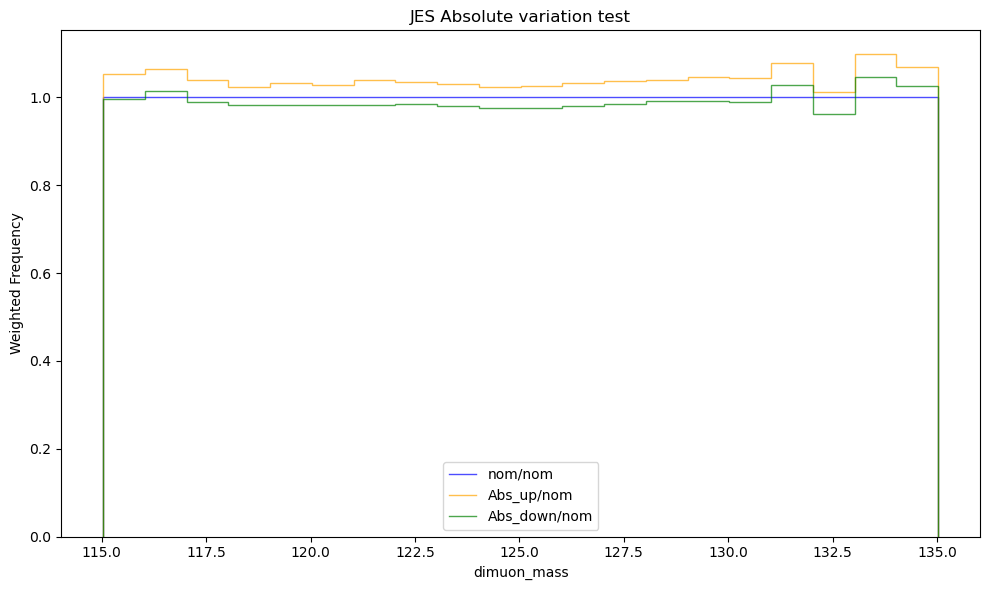

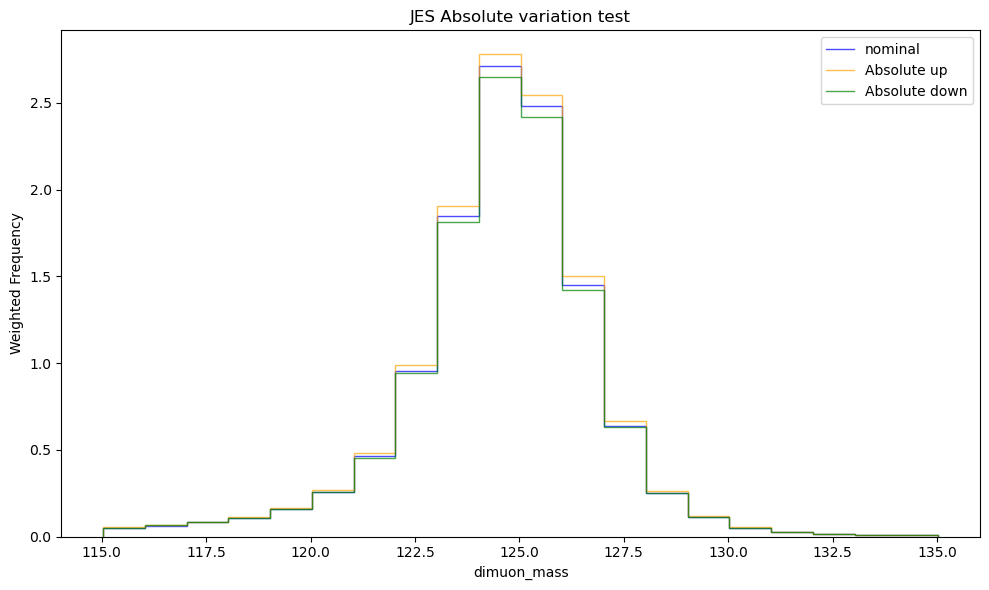

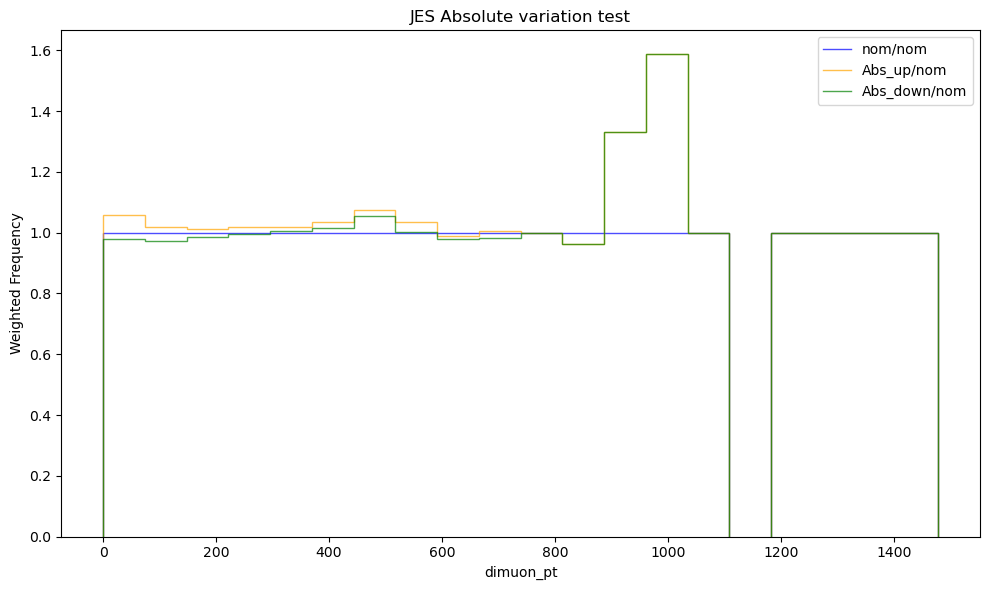

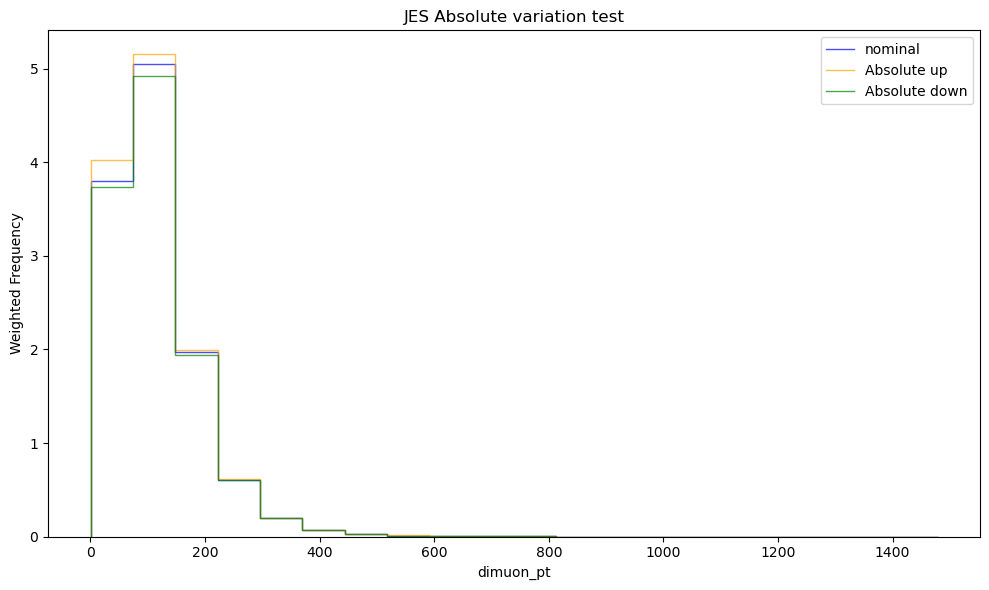

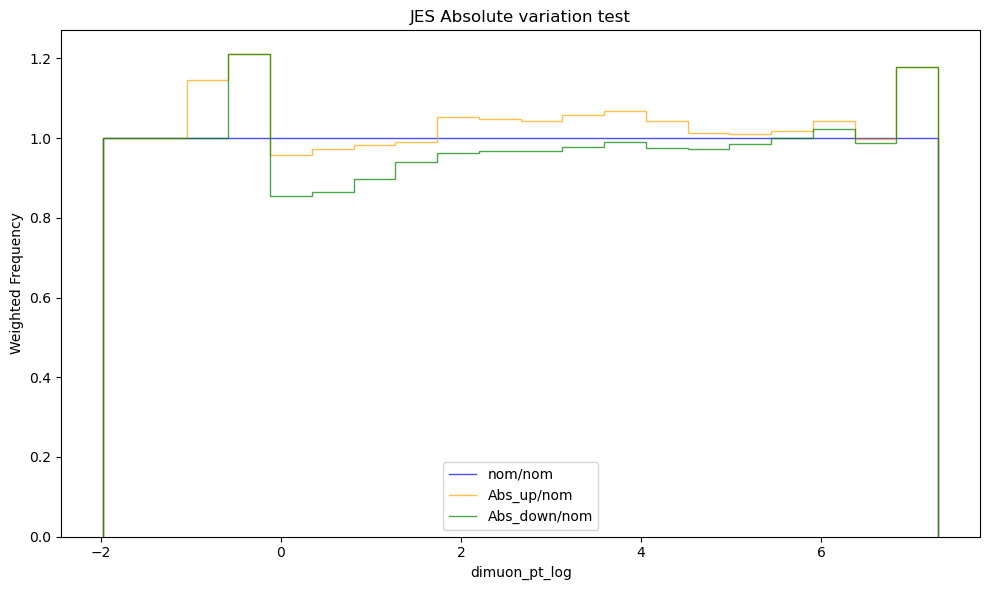

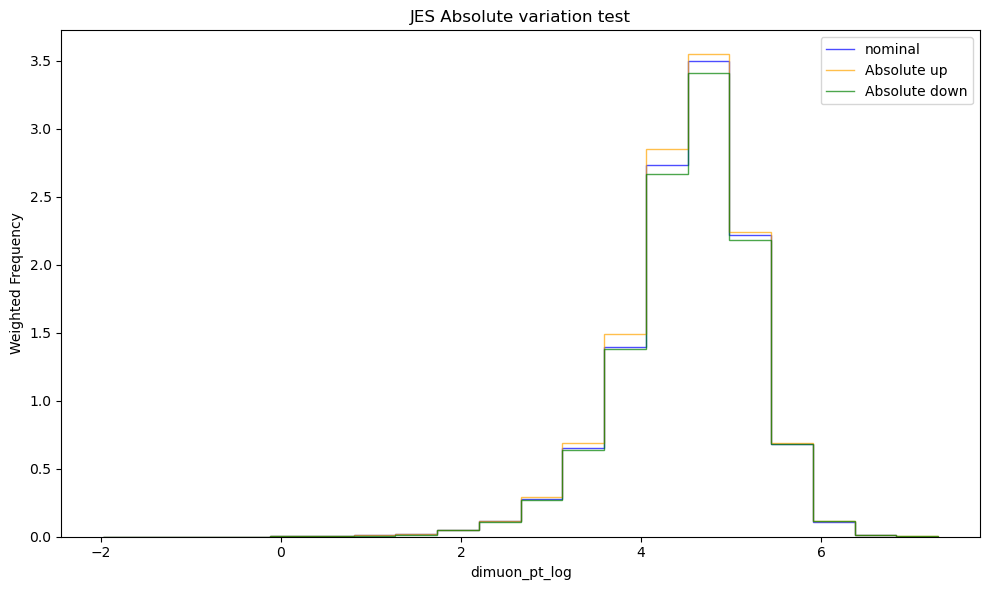

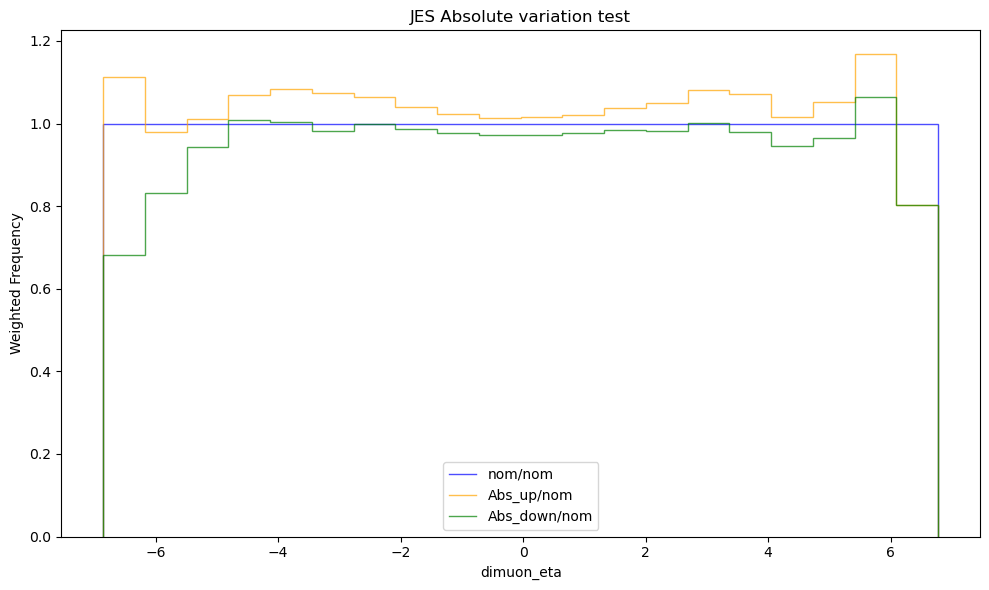

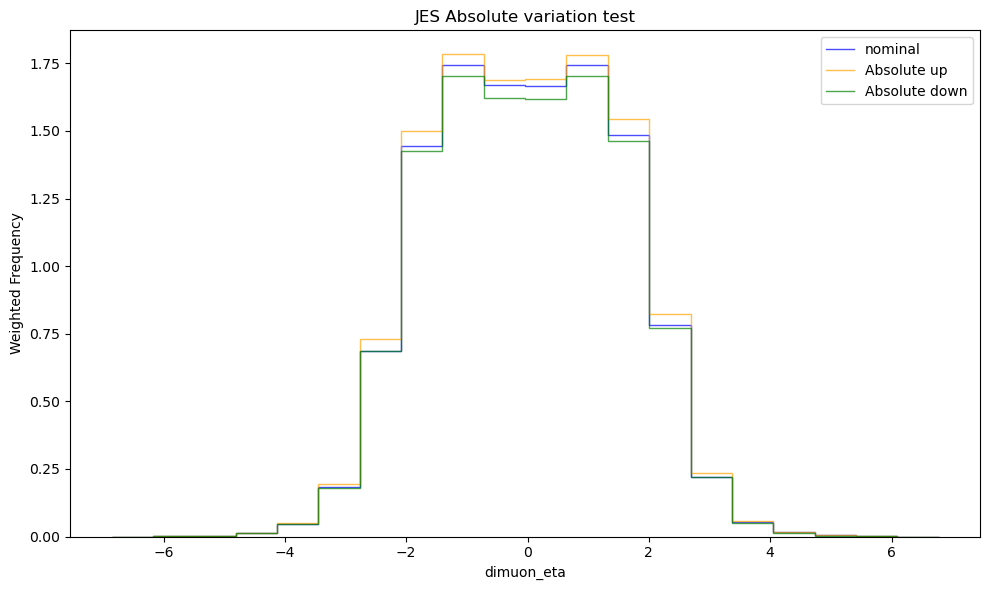

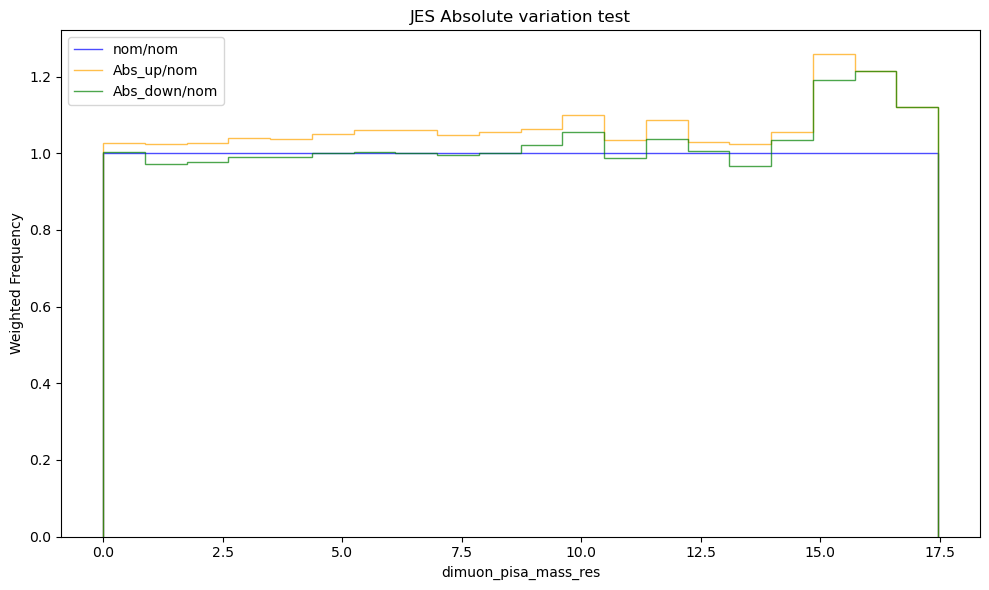

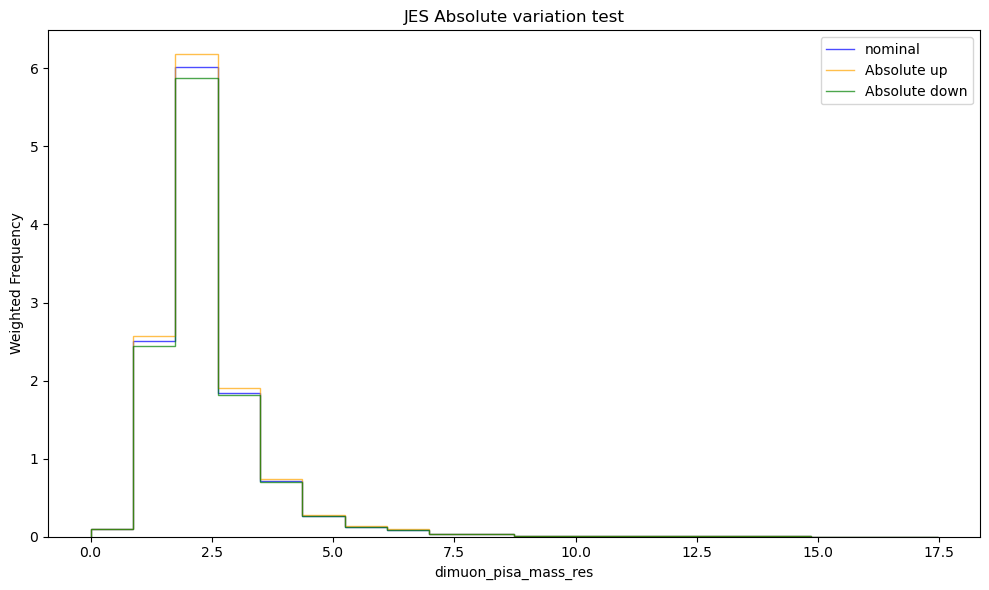

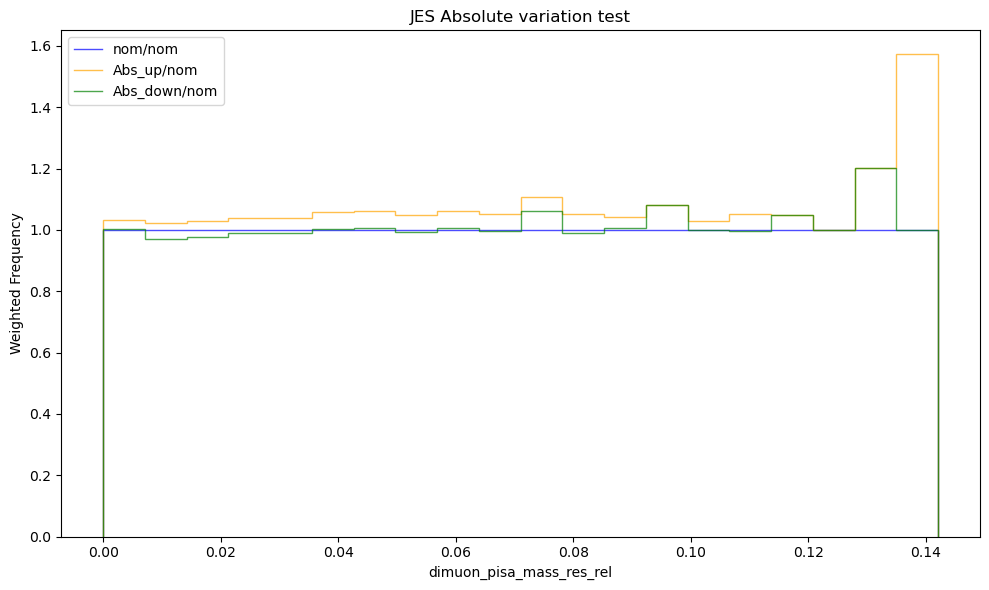

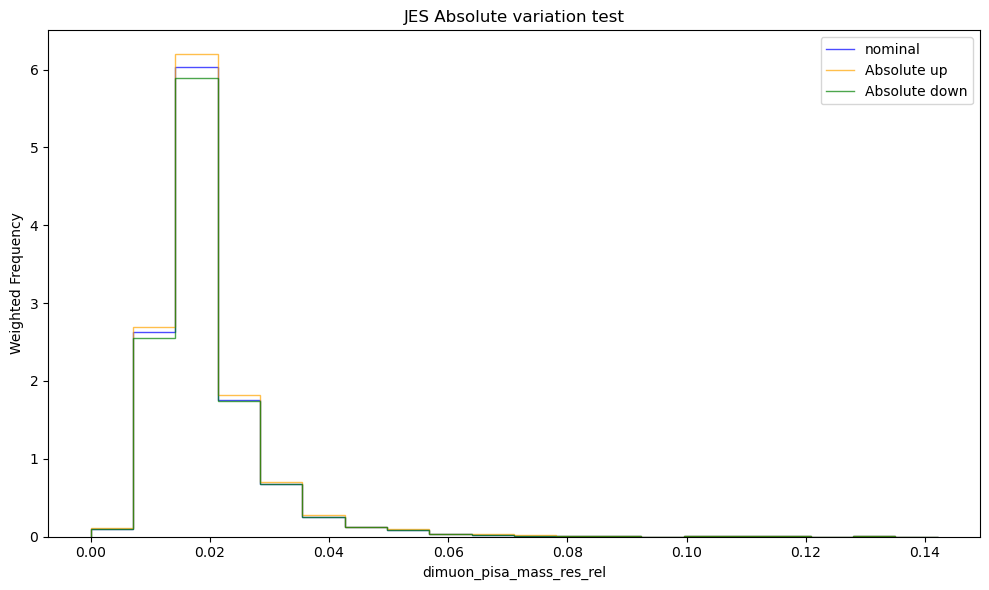

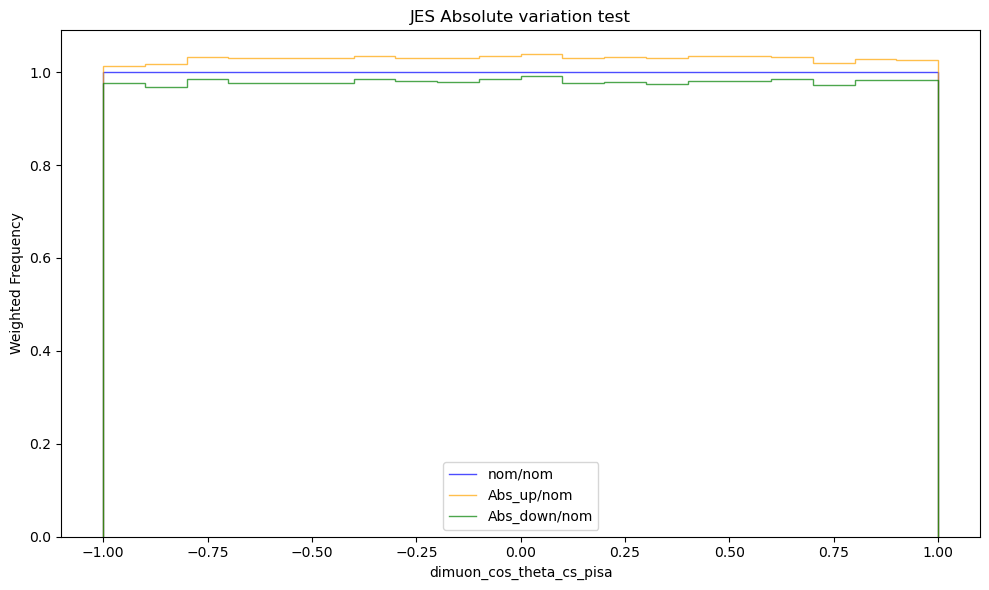

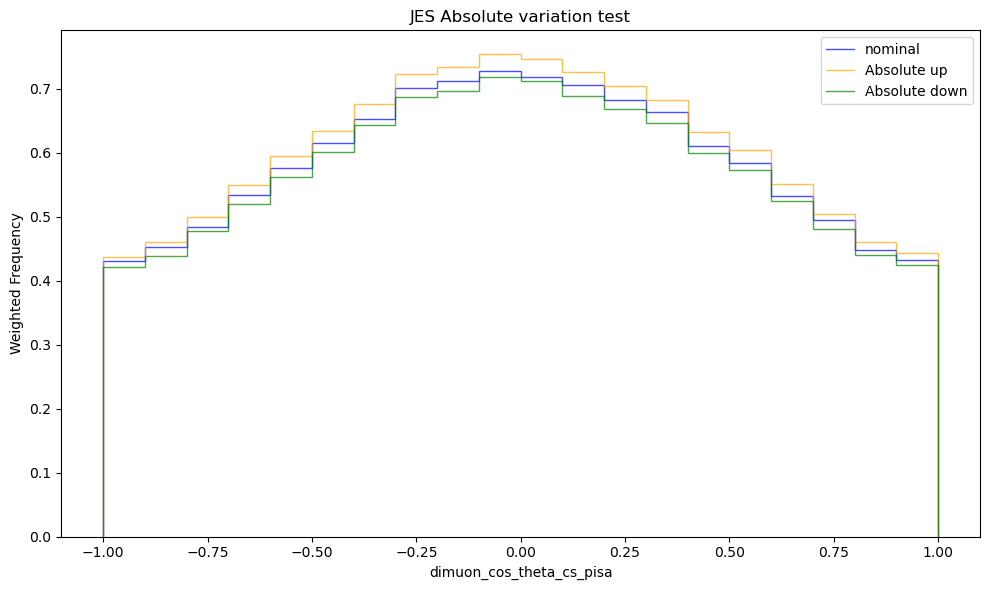

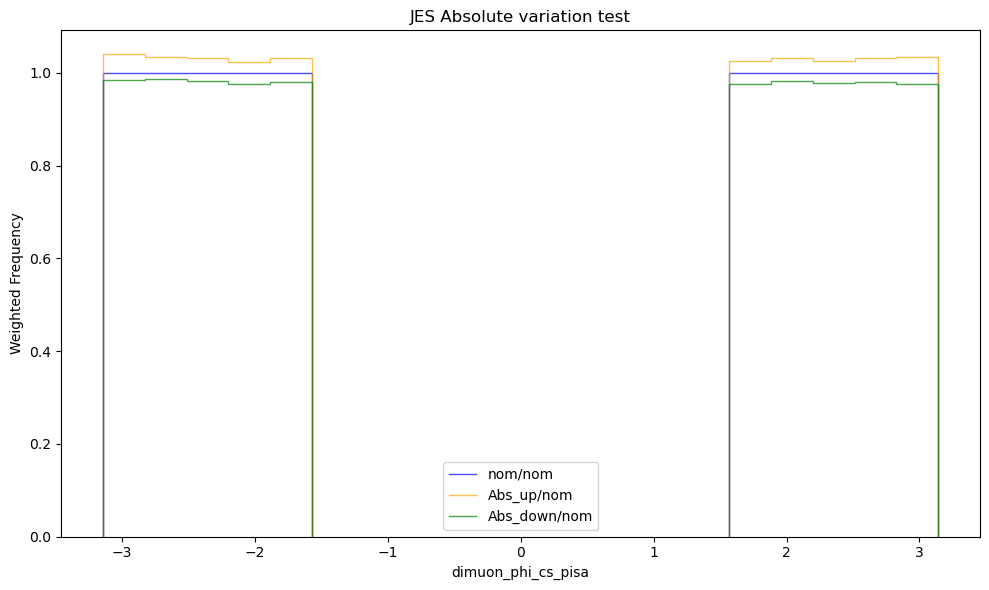

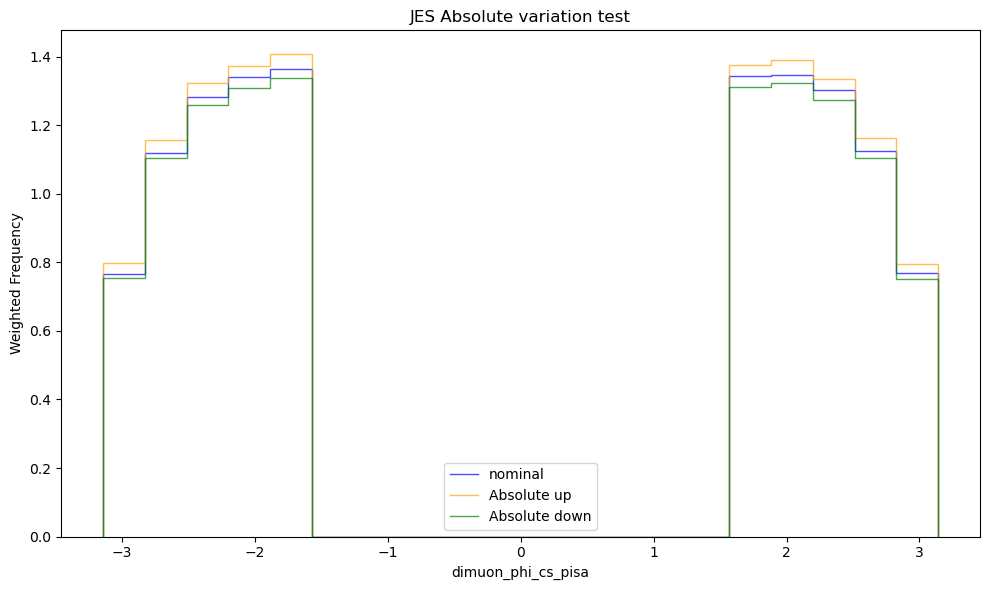

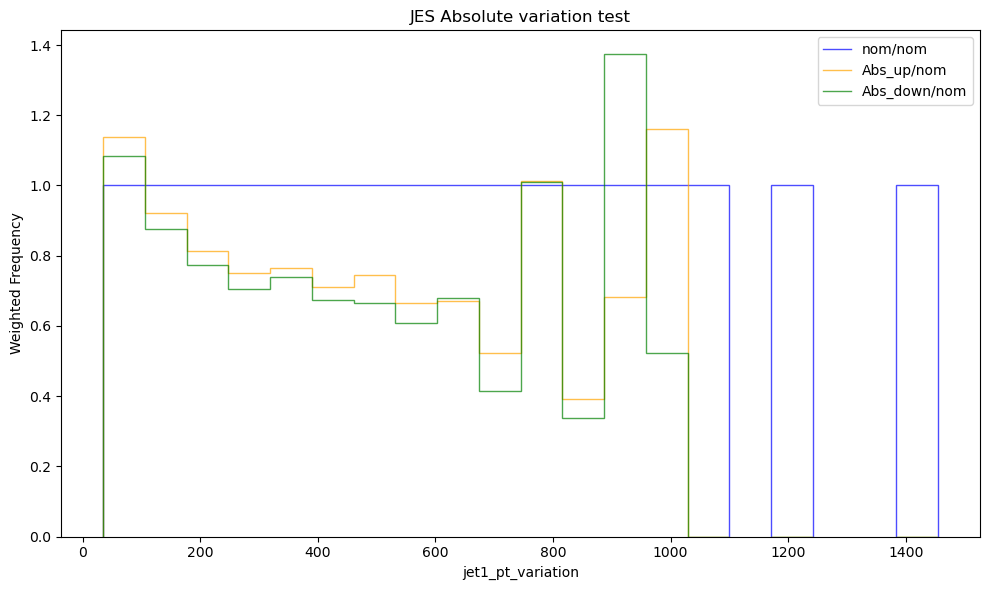

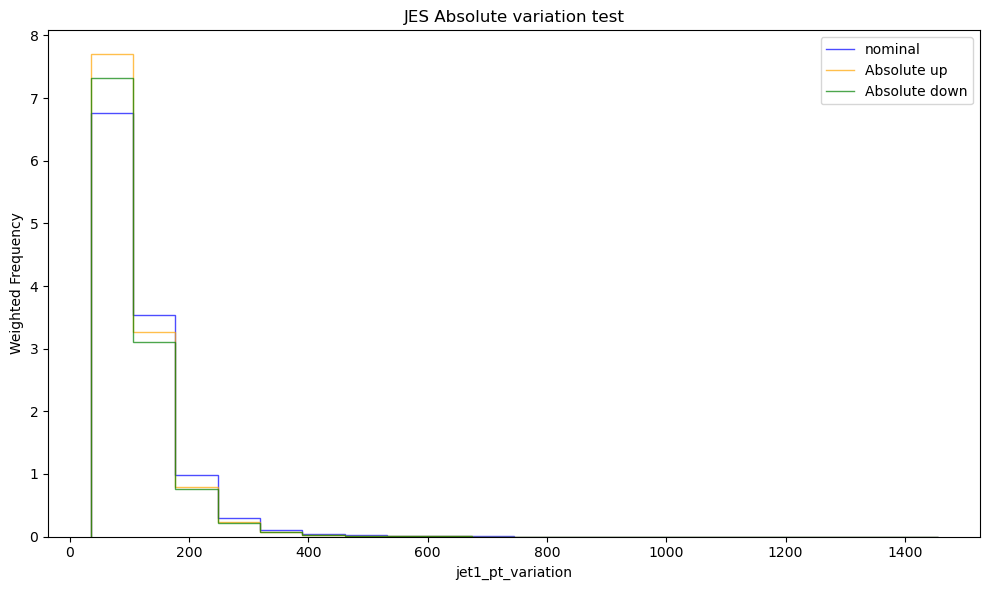

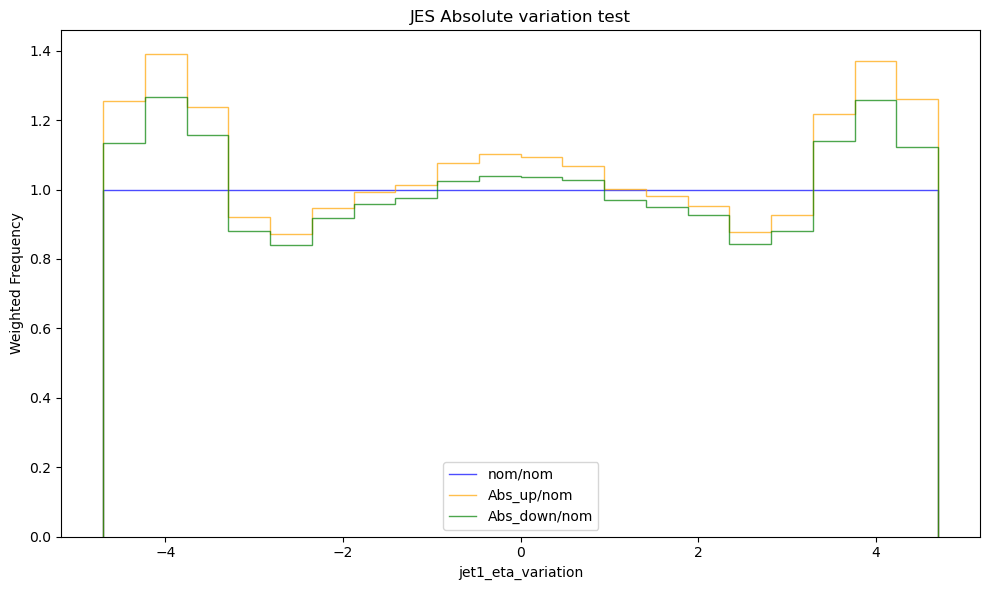

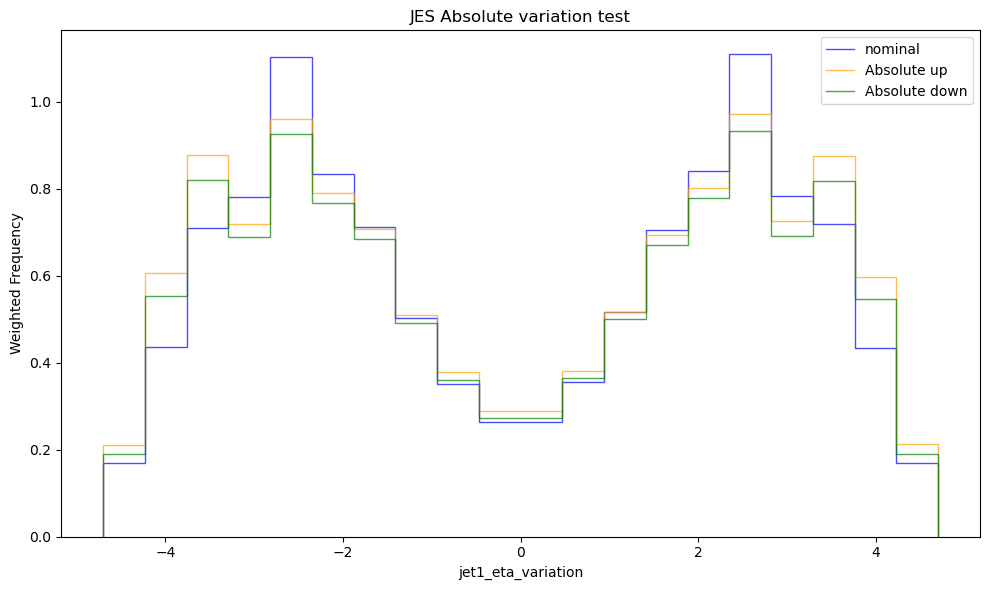

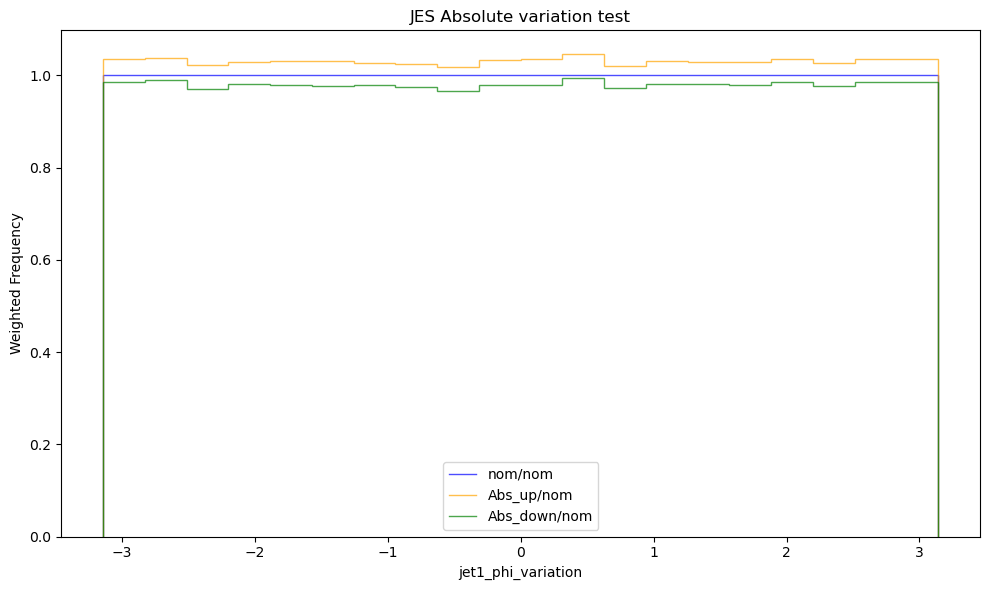

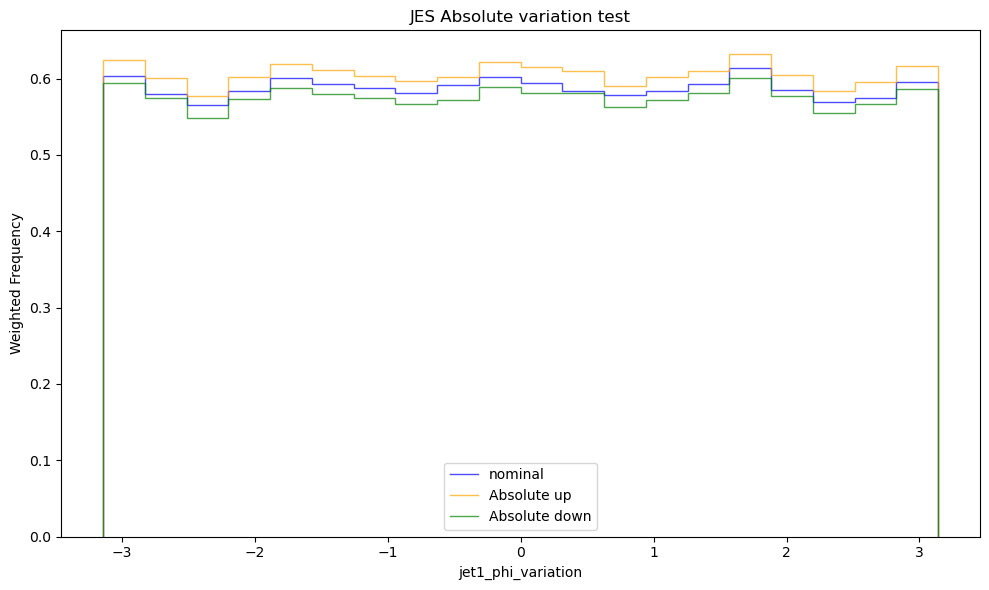

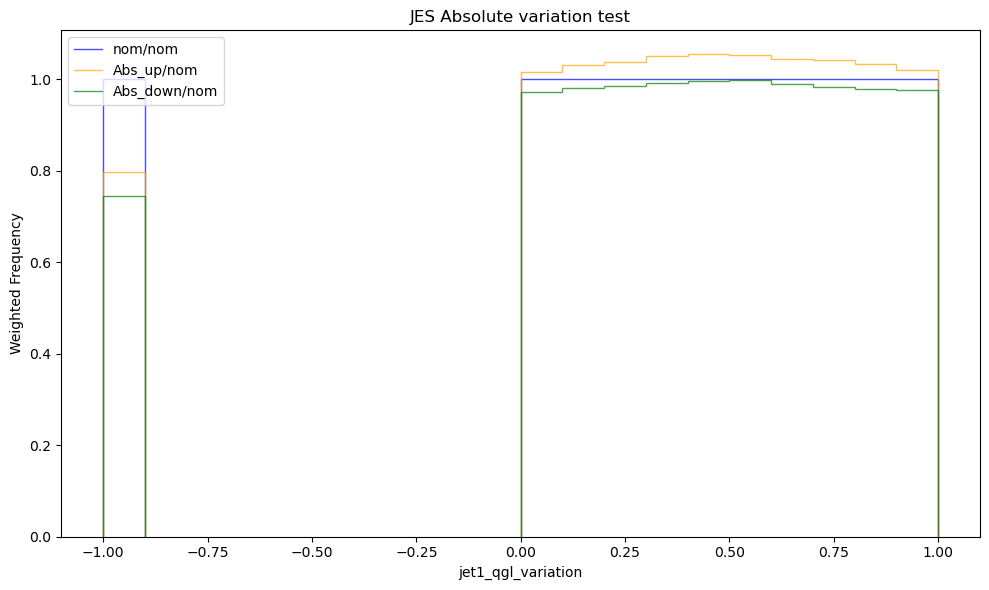

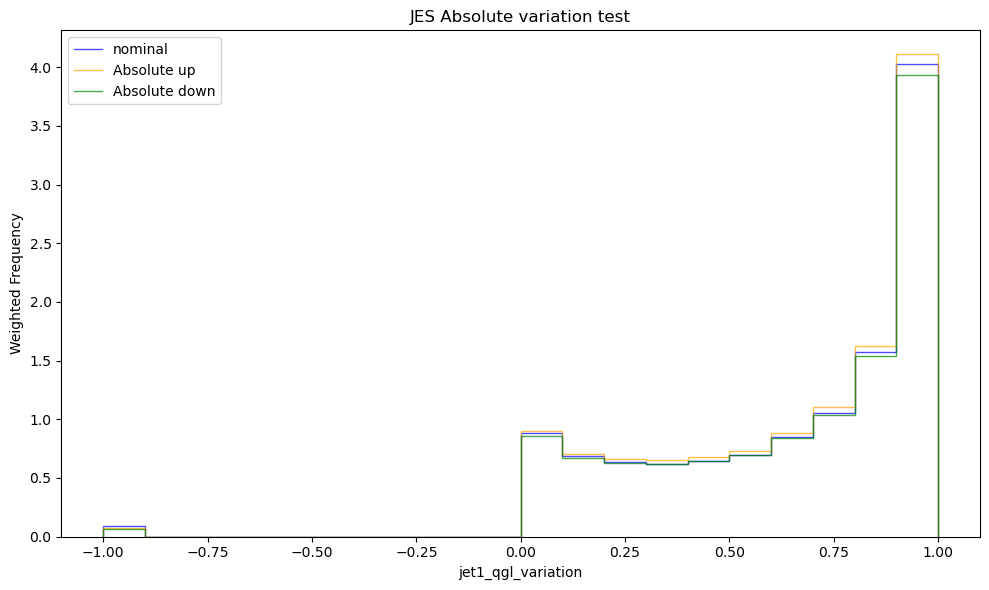

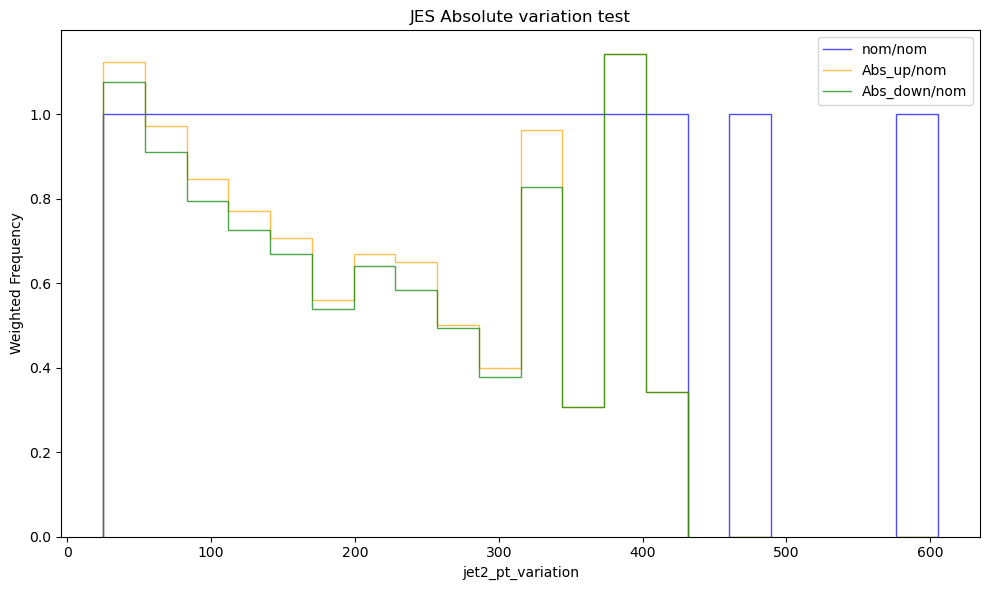

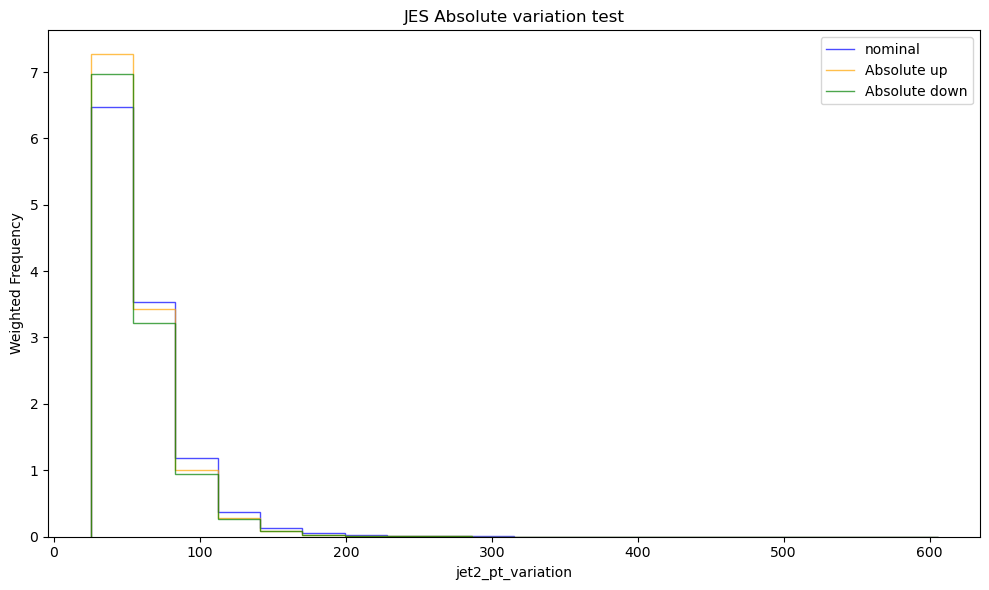

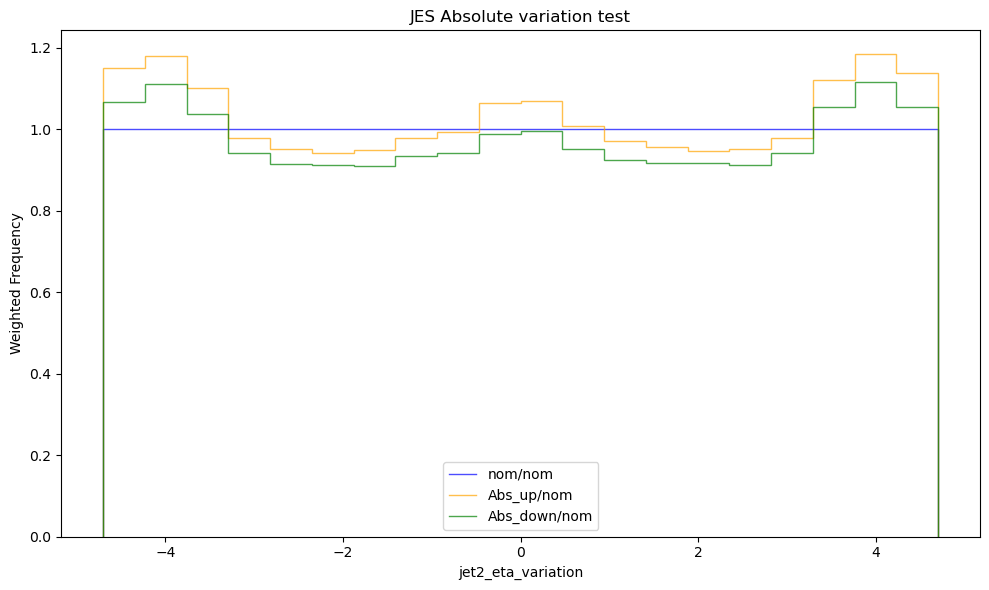

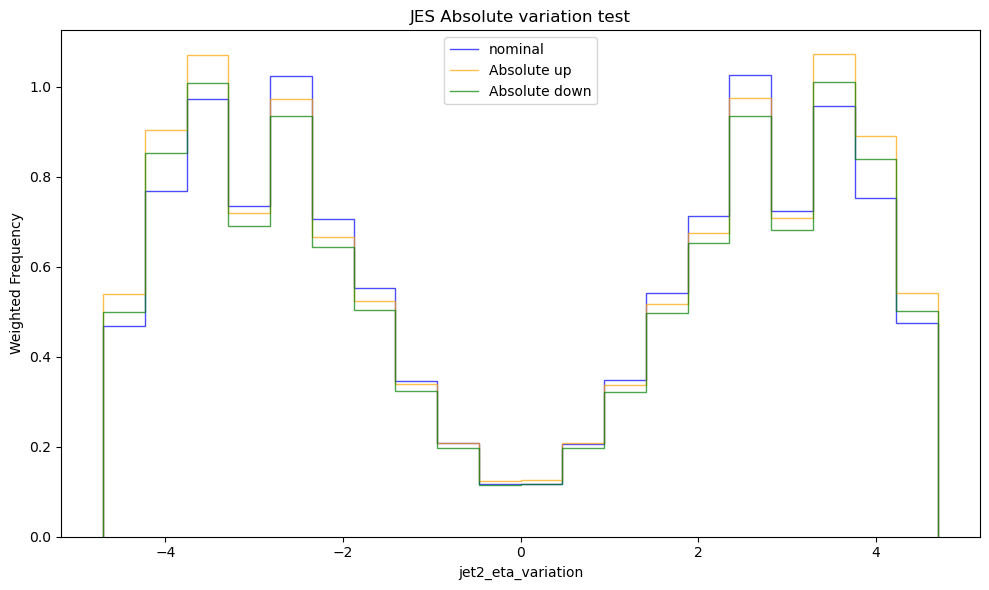

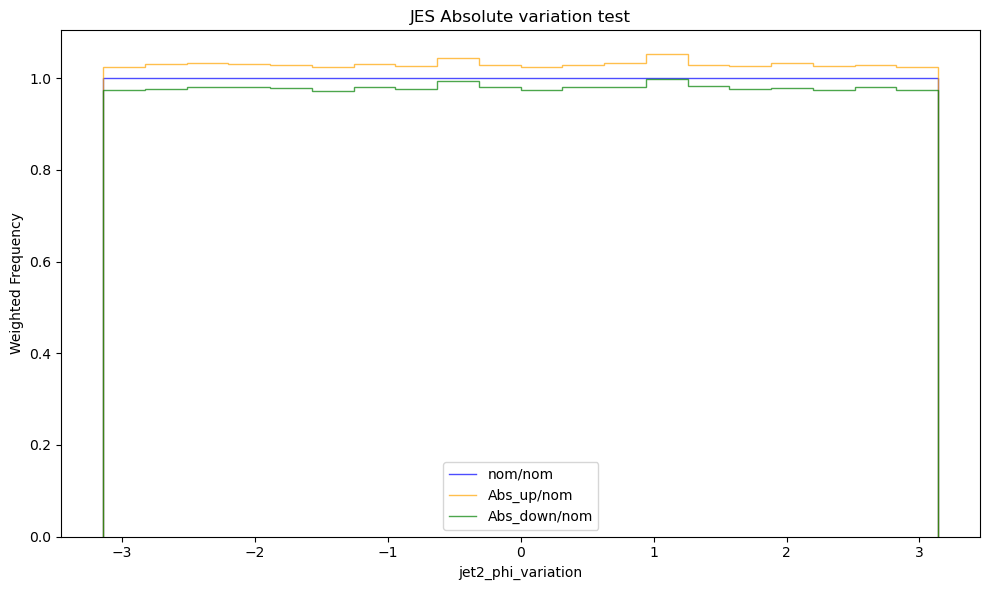

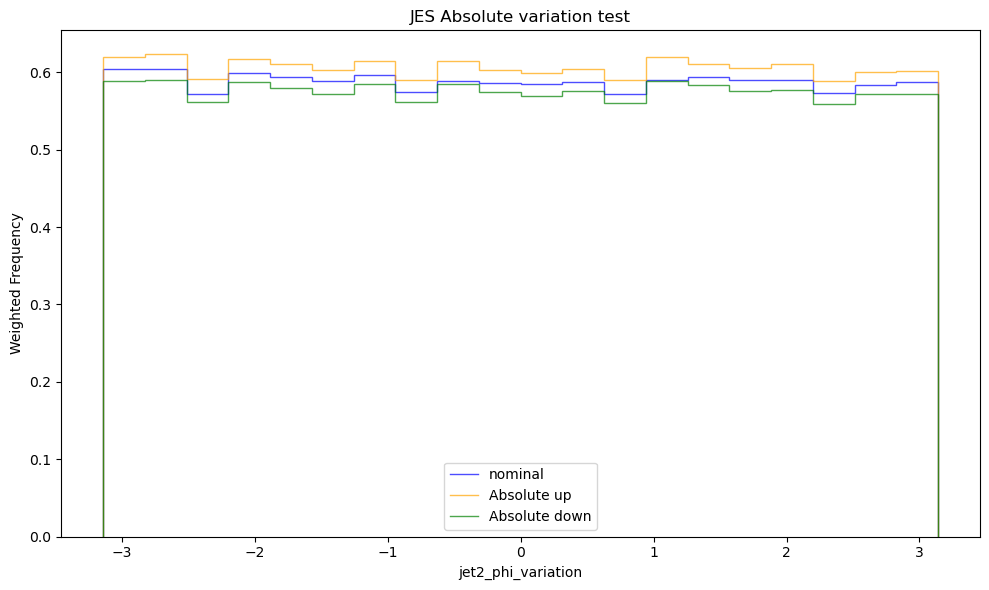

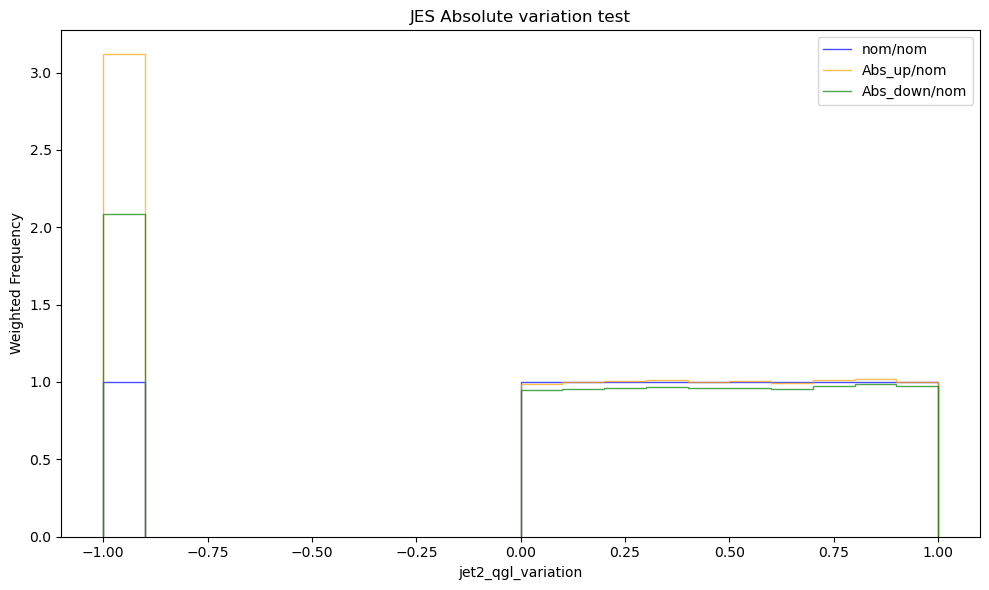

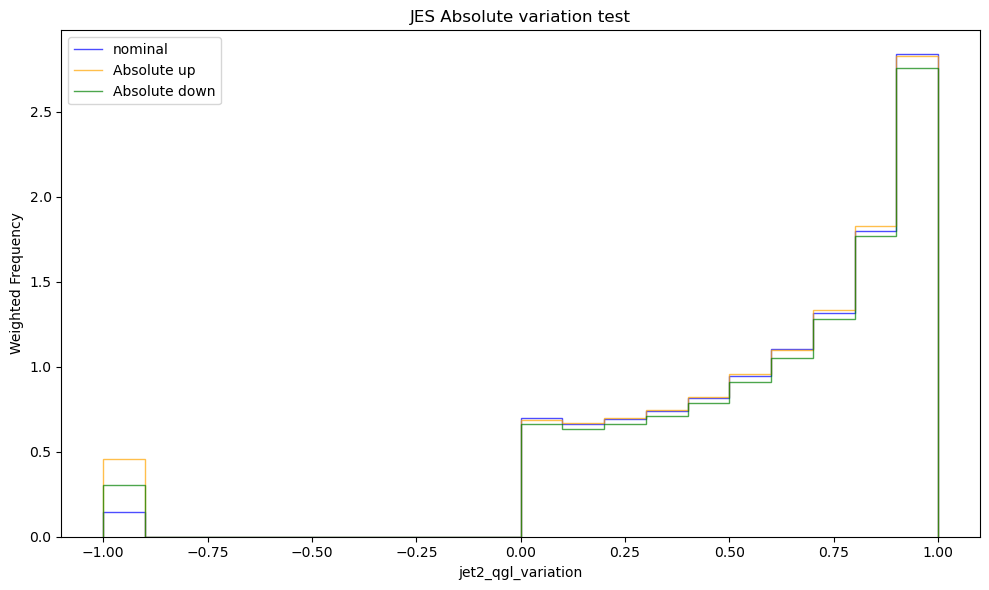

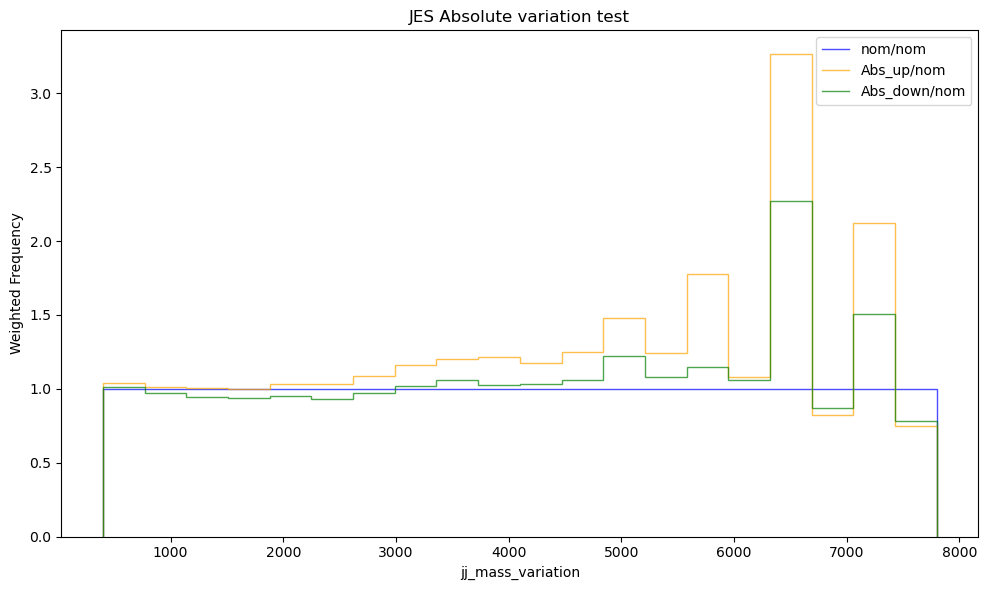

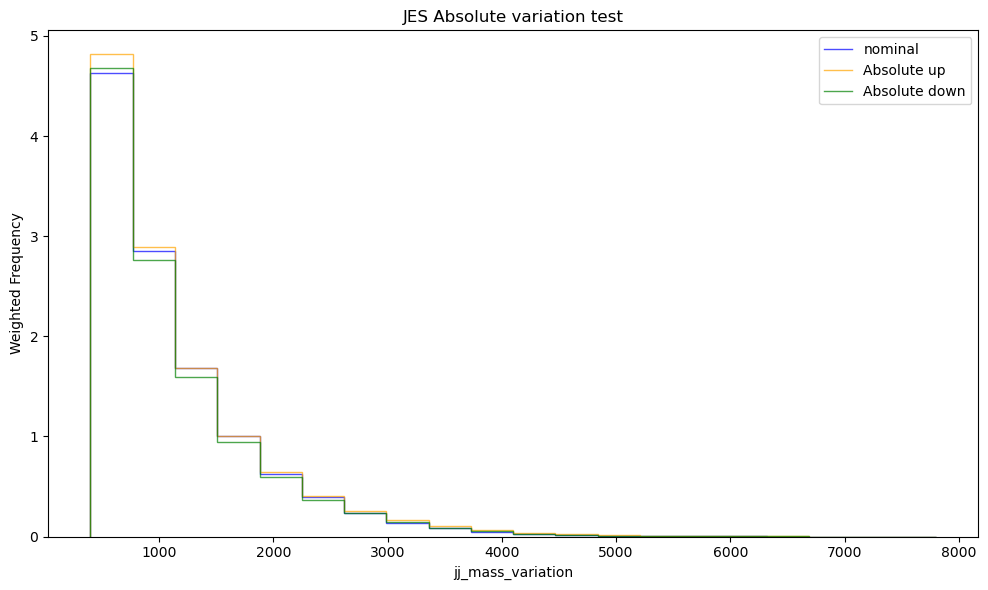

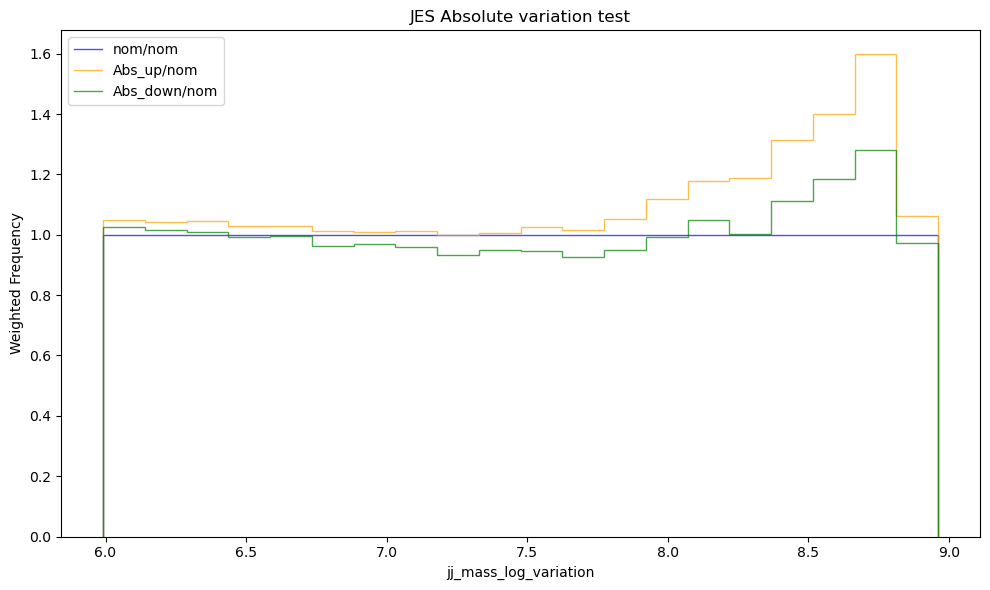

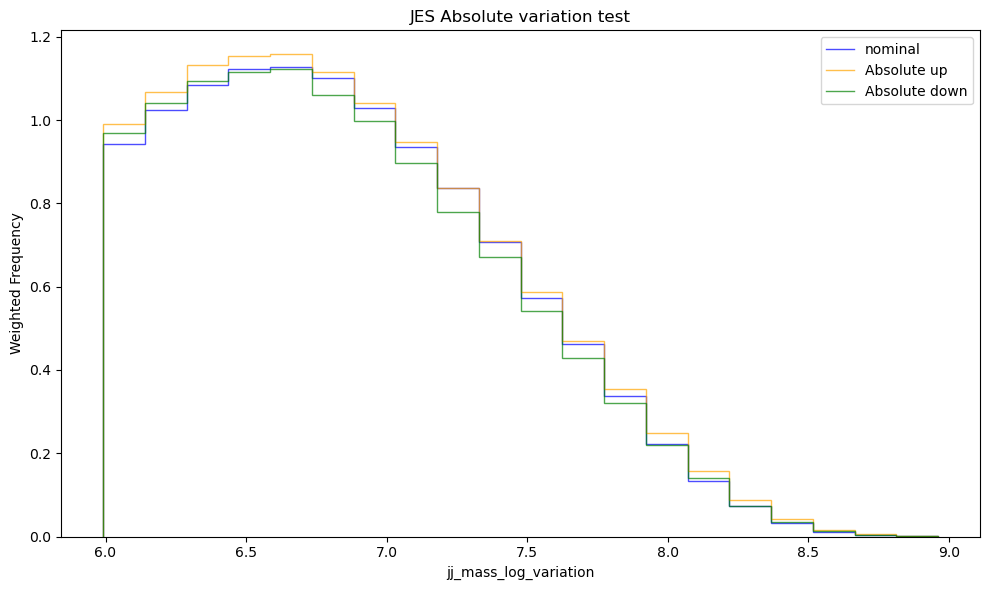

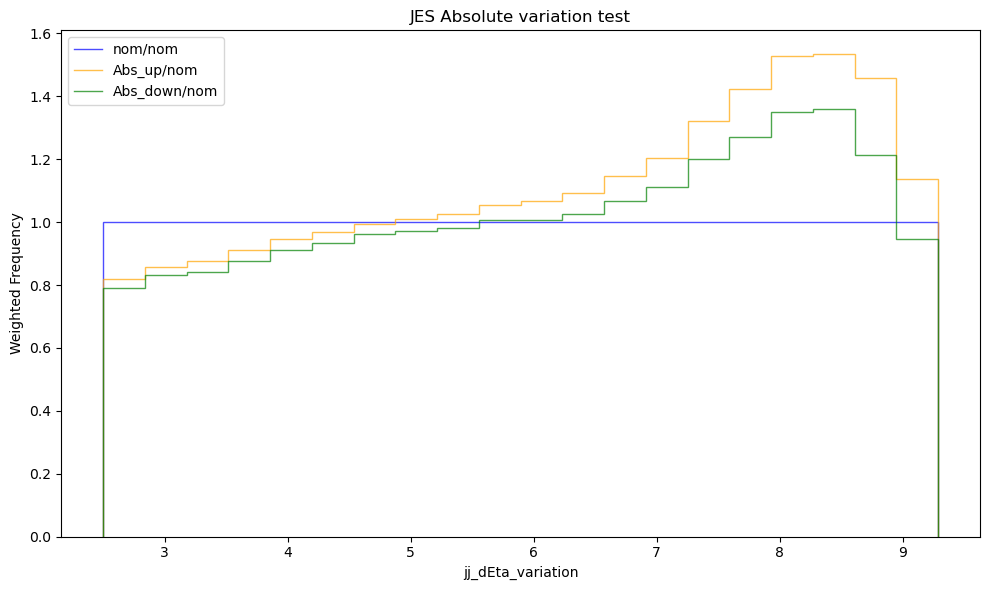

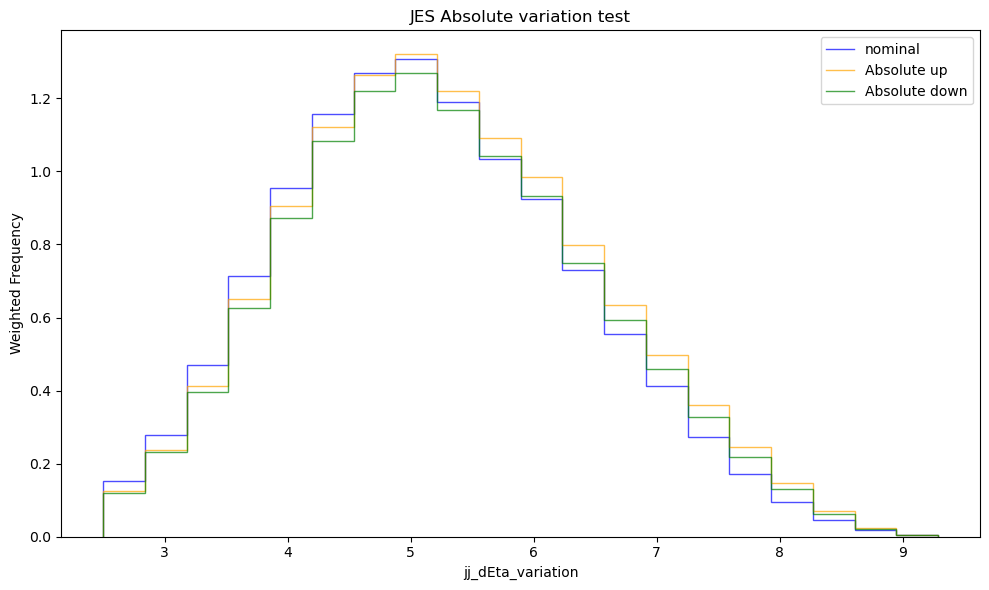

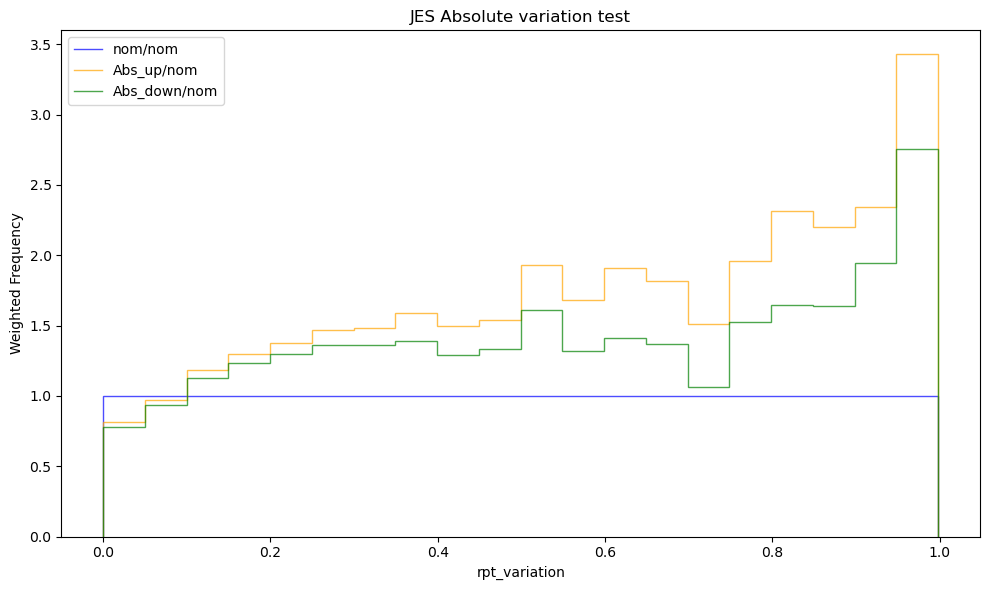

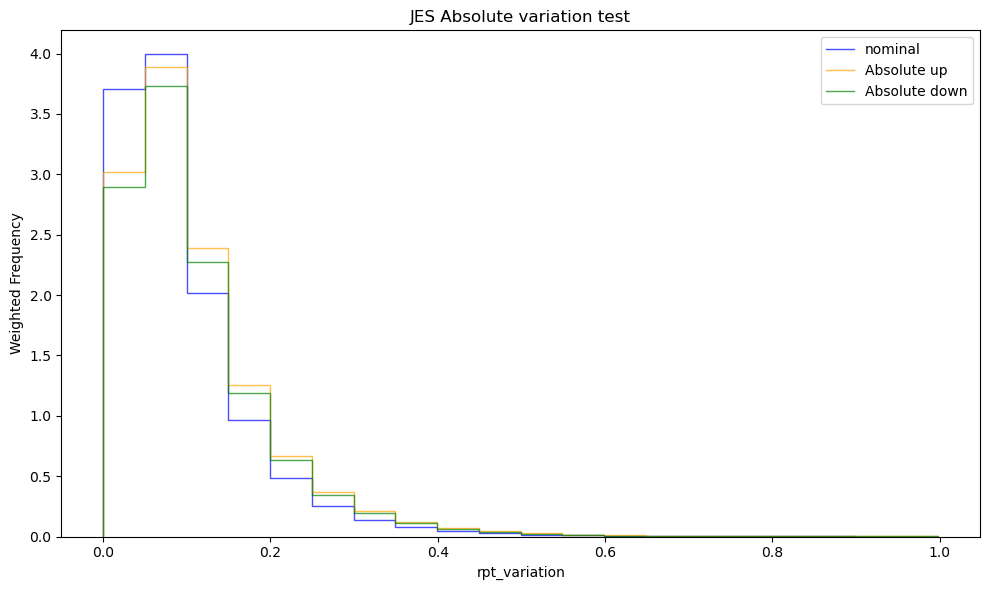

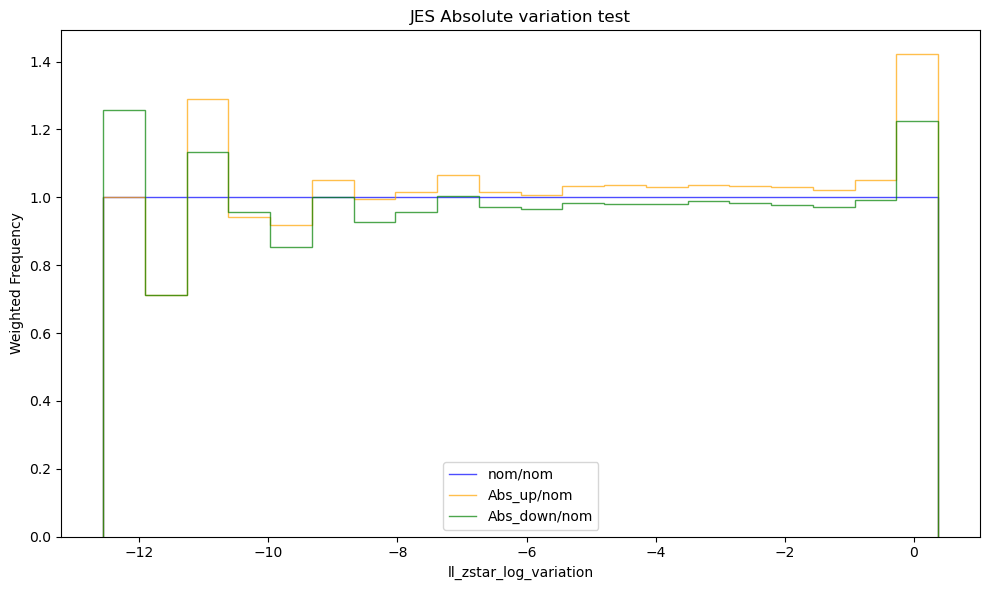

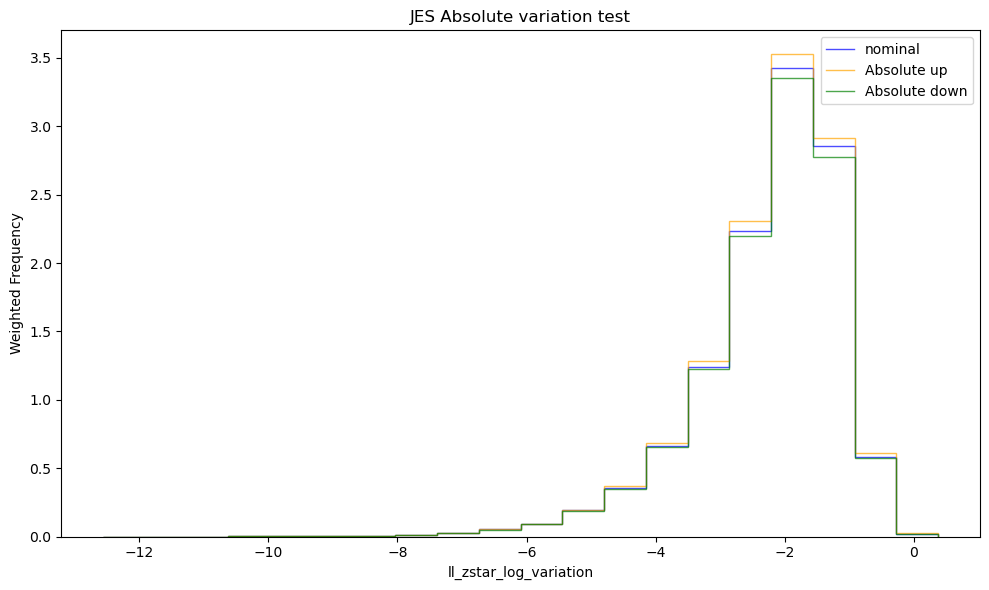

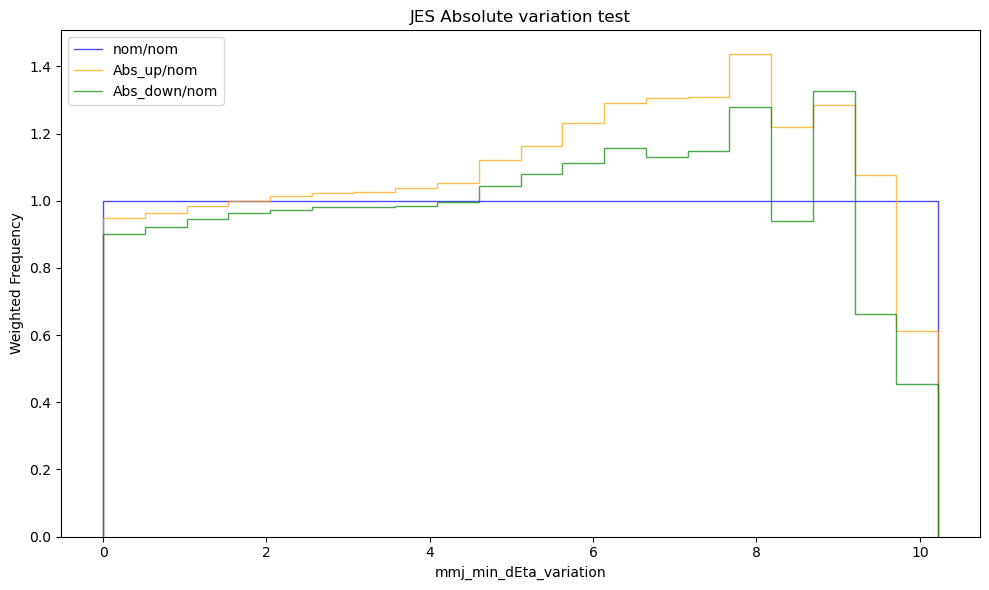

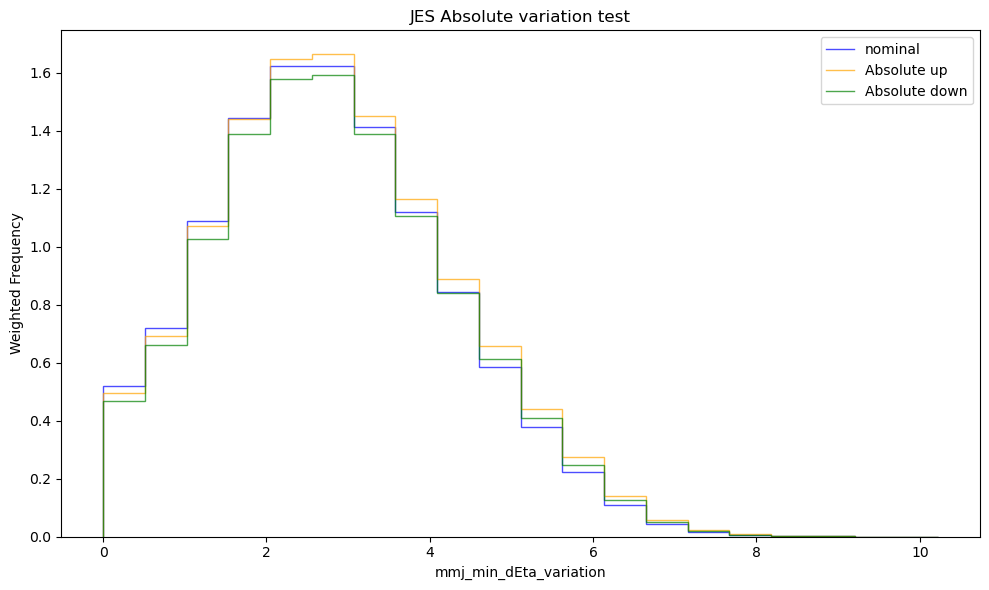

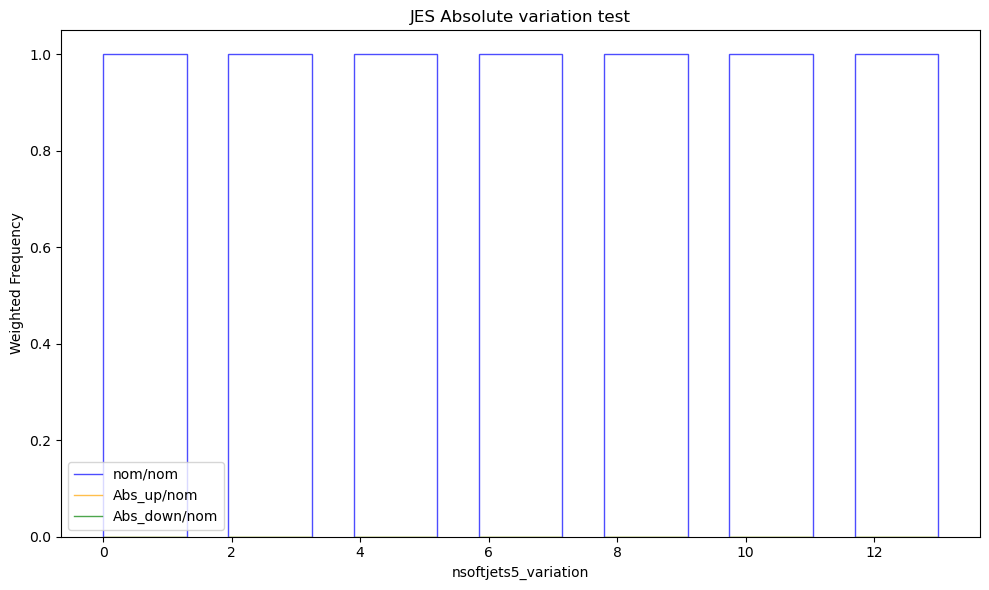

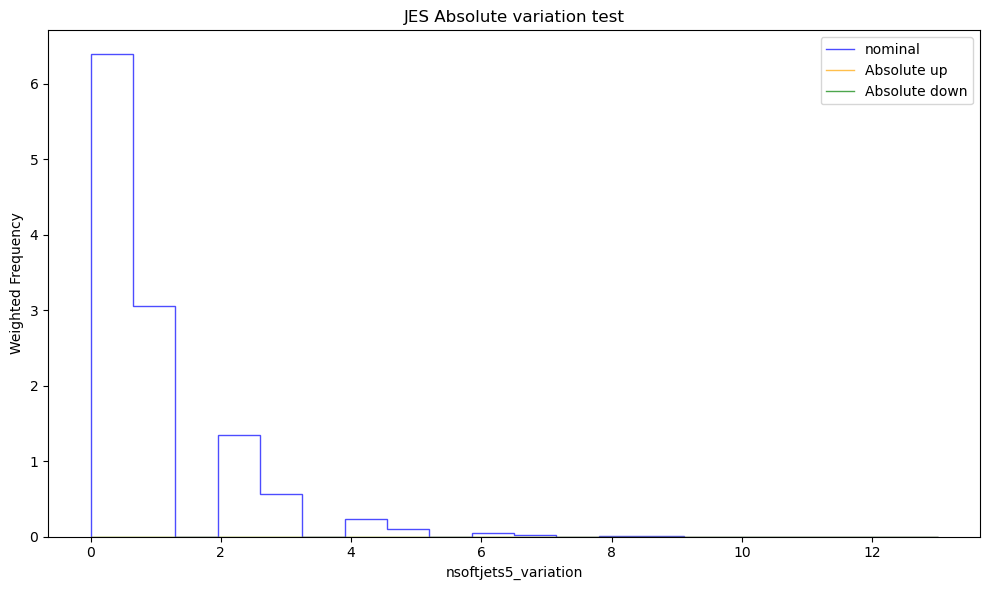

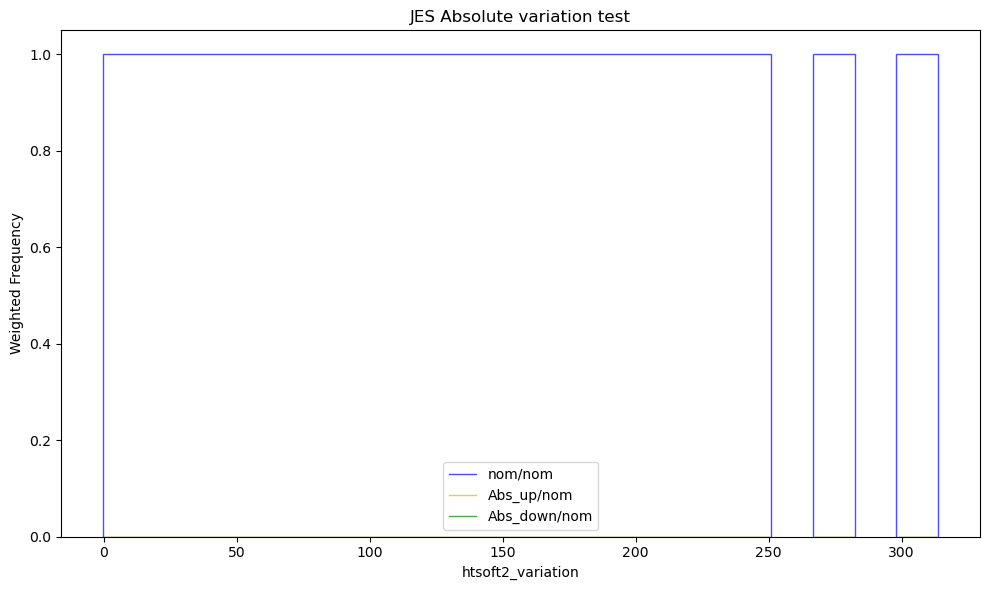

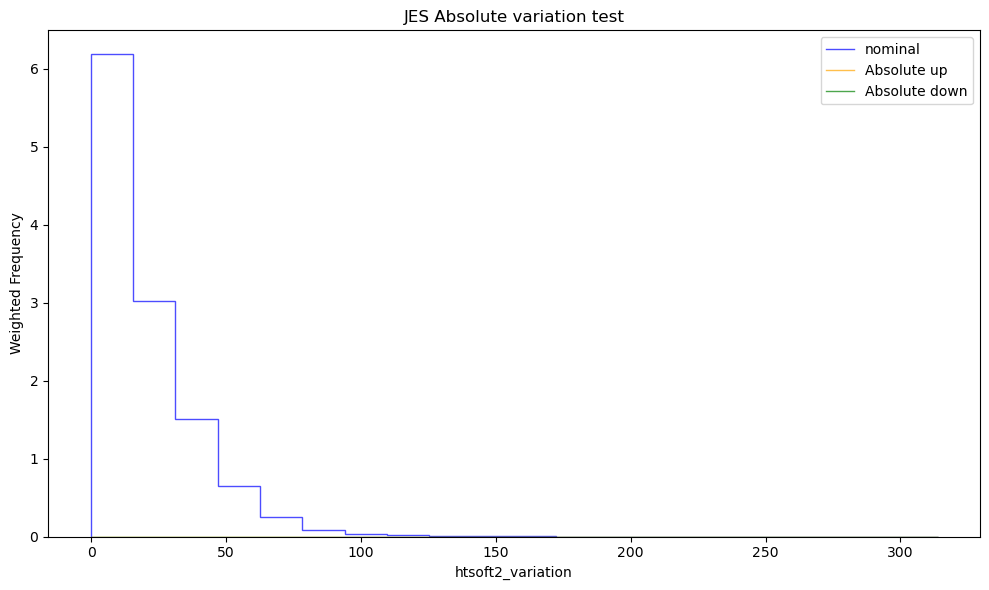

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Generate sample data
# field = "jet1_pt"
field = "dimuon_mass"

input_fields = [
    'dimuon_mass', 'dimuon_pt', 'dimuon_pt_log', 'dimuon_eta', 'dimuon_pisa_mass_res', 'dimuon_pisa_mass_res_rel', 
    'dimuon_cos_theta_cs_pisa', 'dimuon_phi_cs_pisa', 'jet1_pt_variation', 'jet1_eta_variation', 'jet1_phi_variation', 
    'jet1_qgl_variation', 'jet2_pt_variation', 'jet2_eta_variation', 'jet2_phi_variation', 'jet2_qgl_variation', 
    'jj_mass_variation', 'jj_mass_log_variation', 'jj_dEta_variation', 'rpt_variation', 'll_zstar_log_variation', 
    'mmj_min_dEta_variation', 'nsoftjets5_variation', 'htsoft2_variation', 'year'
]

# field = "jj_mass"
# Plot histograms

# data1 = events[f"{field}_nominal"]
# data2 = events_absUp[f"{field}_Absolute_up"] #jj_mass_Absolute_up jj_mass_Absolute_down
# data3 = events_absDown[f"{field}_Absolute_down"]  
for field in input_fields:
    fieldname_nom = field.replace("variation","nominal")
    if fieldname_nom not in events_nominal.fields:
        continue
    variation_name = "Absolute"
    fieldname_up = field.replace("variation",f"{variation_name}_up")
    print(f"fieldname_up: {fieldname_up}")
    fieldname_down = field.replace("variation",f"{variation_name}_down")
    print(f"fieldname_down: {fieldname_down}")
    data1 = events_nominal[f"{fieldname_nom}"]
    data2 = events_absUp[f"{fieldname_up}"] #jj_mass_Absolute_up jj_mass_Absolute_down
    data3 = events_absDown[f"{fieldname_down}"]  
    weights1 = events_nominal.wgt_nominal
    weights2 = events_absUp.wgt_nominal
    weights3 = events_absDown.wgt_nominal
    
    
    
    bin_edges = np.linspace(np.min(data1), np.max(data1), 21)  # 40 bins between -10 and 20
    
    # Compute histograms using np.histogram
    hist1, _ = np.histogram(data1, bins=bin_edges, weights=weights1)
    hist2, _ = np.histogram(data2, bins=bin_edges, weights=weights2)
    hist3, _ = np.histogram(data3, bins=bin_edges, weights=weights3)
    
    base = hist1/hist1
    up_ratio = hist2/hist1
    down_ratio = hist3/hist1
    

    plt.figure(figsize=(10, 6))
    
    plt.stairs(base, bin_edges, label='nom/nom', color='blue', alpha=0.7)
    plt.stairs(up_ratio, bin_edges, label='Abs_up/nom', color='orange', alpha=0.7)
    plt.stairs(down_ratio, bin_edges, label='Abs_down/nom', color='green', alpha=0.7)
    
    plt.title(f'JES {variation_name} variation test')
    plt.xlabel(f'{field}')
    plt.ylabel('Weighted Frequency')
    plt.legend()
    plt.tight_layout()

    save_path = "plots/DNN_input"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(f"{save_path}/{field}_{variation_name}_ratio.png")
    
    plt.figure(figsize=(10, 6))
    plt.stairs(hist1, bin_edges, label='nominal', color='blue', alpha=0.7)
    plt.stairs(hist2, bin_edges, label=f'{variation_name} up', color='orange', alpha=0.7)
    plt.stairs(hist3, bin_edges, label=f'{variation_name} down', color='green', alpha=0.7)
     # Add titles and labels
    plt.title(f'JES {variation_name} variation test')
    plt.xlabel(f'{field}')
    plt.ylabel('Weighted Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_path}/{field}_{variation_name}_statistics.png")
    

In [34]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
up_over_base = hist2/hist1
print(f"up_over_base: {ak.to_numpy(up_over_base)}")
down_over_base = hist3/hist1
print(f"down_over_base: {ak.to_numpy(down_over_base)}")

up_over_base: [       nan 1.09542043 1.14363639 1.10945634 1.11634145 1.04989086
 1.02982821 0.98240362 0.94075701 0.92633717 0.87350391 0.87920823
 0.86041431 0.83671038 0.80084751 0.78963692 0.8085688  0.77557585
 0.79464268 0.75471944 0.71315315 0.74008871 0.71645038 0.67967315
 0.75947454 0.71280255 0.7314199  0.88424349 0.73107689 0.70743541
 0.74102107 0.68299295 0.64045611 0.67485015 0.71437659 0.69303471
 0.74315434 0.70807013 0.81488023]
down_over_base: [       nan 1.17781986 1.19206359 1.12794928 1.10806531 1.0331113
 1.00782659 0.9594892  0.91621358 0.90596363 0.85484806 0.85634341
 0.83896893 0.81583444 0.78294209 0.77117402 0.79584319 0.74325899
 0.79124252 0.72438356 0.70135784 0.70986678 0.6764616  0.68163439
 0.71130333 0.6941412  0.75189781 0.82443907 0.70698997 0.68448862
 0.69684922 0.65352498 0.59807223 0.66712249 0.65188682 0.76938705
 0.65094857 0.73199869 0.78456683]


In [ ]:
def getYield(events, wgts2deactivate):
    wgt_nominal = ak.fill_none(events.wgt_nominal, value=0.0)
    for wgt in wgts2deactivate:
        # print(f"wgt: {wgt}")
        seperate_wgt = ak.fill_none(events[wgt], value=1.0)
        wgt_nominal = wgt_nominal / seperate_wgt
    return wgt_nominal



In [9]:
fields2deactivate

['separate_wgt_btag_wgt',
 'separate_wgt_muID',
 'separate_wgt_muIso',
 'separate_wgt_muTrig',
 'separate_wgt_nnlops',
 'separate_wgt_pu_wgt',
 'separate_wgt_puid_wgt',
 'separate_wgt_qgl_wgt']

In [17]:
import itertools
import numpy as np

def get_combinations(input_list, n):
    """
    Get all combinations of the elements in input_list with length n.

    :param input_list: List of elements to generate combinations from.
    :param n: Length of each combination.
    :return: List of combinations.
    """
    return list(itertools.combinations(input_list, n))

# Example usage:
N = len(fields2deactivate)

for ix in range(N):
    combinations = get_combinations(fields2deactivate, ix)
    for combination in combinations:
        # print(f"combination for N {N}: {combination}")
        weight = getYield(events, combination)
        nan_filter = ~np.isnan(weight)
        weight=  weight[nan_filter]
        # print(np.any(np.isnan(weight)))
        wgt_sum = ak.sum(weight)
        print(f"weight sum with {combination} deactivated: {wgt_sum}")
    




weight sum with () deactivated: 9.276314794252585
weight sum with ('separate_wgt_btag_wgt',) deactivated: 9.386733803743226
weight sum with ('separate_wgt_muID',) deactivated: 9.341560990166656
weight sum with ('separate_wgt_muIso',) deactivated: 9.272695270067139
weight sum with ('separate_wgt_muTrig',) deactivated: 9.29503960431412
weight sum with ('separate_wgt_nnlops',) deactivated: 10.340281279388151
weight sum with ('separate_wgt_pu_wgt',) deactivated: 9.480768790270428
weight sum with ('separate_wgt_puid_wgt',) deactivated: 9.306167909550592
weight sum with ('separate_wgt_qgl_wgt',) deactivated: 9.444216459933452
weight sum with ('separate_wgt_btag_wgt', 'separate_wgt_muID') deactivated: 9.45289528241191
weight sum with ('separate_wgt_btag_wgt', 'separate_wgt_muIso') deactivated: 9.382853626126057
weight sum with ('separate_wgt_btag_wgt', 'separate_wgt_muTrig') deactivated: 9.405696232033108
weight sum with ('separate_wgt_btag_wgt', 'separate_wgt_nnlops') deactivated: 10.4505769

In [8]:

# events_data = applyGGH_cutV1(events_data)


# data_yield = ak.num(events_data.dimuon_mass, axis=0)
# # ak.to_dataframe(events_data).to_csv("event_dataC_V1.csv")
# df = pd.DataFrame({field: ak.fill_none(events_data[field], value=-999.9) for field in events_data.fields})
# print(f"data_yield : {data_yield}")
# total_integral += data_yield

# sumWgt = ak.sum(events.wgt_nominal)
sumWgt = ak.num(events.wgt_nominal, axis=0)

sumWgt

array(3423)

In [1]:
import uproot

In [4]:
file = uproot.open("/eos/purdue/store/group/local/hmm/FSRnano18MC_NANOV10b/VBFHToMuMu_M-125_TuneCP5_13TeV-powheg-pythia_dipole_fixed/RunIISummer16MiniAODv3_FSRnano18MC_NANOV10b_9f12feadf56f2d534f5f/200414_113904/0000/nano18MC_NANO_1.root")

In [6]:
file["Events"].keys()

['run',
 'luminosityBlock',
 'event',
 'HTXS_Higgs_pt',
 'HTXS_Higgs_y',
 'HTXS_stage1_1_cat_pTjet25GeV',
 'HTXS_stage1_1_cat_pTjet30GeV',
 'HTXS_stage1_1_fine_cat_pTjet25GeV',
 'HTXS_stage1_1_fine_cat_pTjet30GeV',
 'HTXS_stage_0',
 'HTXS_stage_1_pTjet25',
 'HTXS_stage_1_pTjet30',
 'HTXS_njets25',
 'HTXS_njets30',
 'btagWeight_CSVV2',
 'btagWeight_DeepCSVB',
 'CaloMET_phi',
 'CaloMET_pt',
 'CaloMET_sumEt',
 'ChsMET_phi',
 'ChsMET_pt',
 'ChsMET_sumEt',
 'nCorrT1METJet',
 'CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'nElectron',
 'Electron_deltaEtaSC',
 'Electron_dr03EcalRecHitSumEt',
 'Electron_dr03HcalDepth1TowerSumEt',
 'Electron_dr03TkSumPt',
 'Electron_dr03TkSumPtHEEP',
 'Electron_dxy',
 'Electron_dxyErr',
 'Electron_dz',
 'Electron_dzErr',
 'Electron_eCorr',
 'Electron_eInvMinusPInv',
 'Electron_energyErr',
 'Electron_eta',
 'Electron_hoe',
 'Electron_ip3d',
 'Electron_jetPtRelv2',
 'Electron_jetRelIso',
 'E

In [8]:
import awkward as ak

jets = ak.from_parquet("../test.parquet")

In [31]:
jets['JER']['up'].fields
# jets['JES_FlavorQCD'].fields
jet_columns = [
            "pt",
            "eta",
            "phi",
            "jetId",
            "qgl",
            "puId",
            "mass",
            "btagDeepB",
            "has_matched_gen",
        ]

In [32]:
# jets['JES_FlavorQCD']['up'].fields
jets[jet_columns]

<Array [[{pt: 94.2, eta: ..., ...}, ...], ...] type='100 * var * {pt: float...'>

In [34]:
jer_mask ={
    "jer1" : abs(jets.eta) < 1.93,
    "jer2" : (abs(jets.eta) > 1.93) & (abs(jets.eta) < 2.5),
    "jer3" : (abs(jets.eta) > 2.5) & (abs(jets.eta) < 3.0) & (jets.pt < 50),
    "jer4" : (abs(jets.eta) > 2.5) & (abs(jets.eta) < 3.0) & (jets.pt > 50),
    "jer5" : (abs(jets.eta) > 3.0) & (abs(jets.eta) < 5.0) & (jets.pt < 50),
    "jer6" : (abs(jets.eta) > 3.0) & (abs(jets.eta) < 5.0) & (jets.pt > 50),
}

In [38]:
for mask in jer_mask.values():
    # print(ak.any(ak.is_none(mask)))
    print(mask)

[[True, False, True, False, False, True, False, True, False], ..., [True, ...]]
[[False, False, False, False, True, False, False, False, True], ..., [...]]
[[False, False, False, False, False, False, True, False, False], ..., [...]]
[[False, False, False, False, False, False, False, False, False], ..., [...]]
[[False, False, False, True, False, False, False, False, False], ..., [...]]
[[False, True, False, False, False, False, False, False, False], ..., [...]]


In [39]:
jets_nominal = jets[jet_columns]
jets_jer_up = jets['JER']['up'][jet_columns]
jets_jer_down = jets['JER']['down'][jet_columns]

In [43]:
abs(jets_nominal.eta)

<Array [[1.36, 3.88, 0.587, ..., 2.9, 1.64, 2], ...] type='100 * var * float32'>

In [44]:
jet_final_up = ak.where(jer_mask["jer1"], jets_jer_up, jets_nominal)

In [45]:
jet_final_up

<Array [[{pt: 86.6, eta: ..., ...}, ...], ...] type='100 * var * {pt: float...'>

In [46]:
jets_nominal

<Array [[{pt: 94.2, eta: ..., ...}, ...], ...] type='100 * var * {pt: float...'>

In [47]:
jets_jer_up

<Array [[{pt: 86.6, eta: ..., ...}, ...], ...] type='100 * var * {pt: float...'>